Notebook 05: Business Insights & Recommendation System

---

# 05 – Business Insights & Recommendation System



## Sistema Inteligente de Retenção de Clientes

---

**Autor:** Ivan  
**Dataset:** Telco Customer Churn (modelo treinado no Notebook 04)  
**Objetivo:** Transformar predições em ações de negócio e calcular impacto financeiro

### Estrutura do Notebook

---

1. Carregamento do Modelo e Dados

2. Geração de Predições para Base Completa
3. Segmentação de Clientes por Risco
4. Sistema de Recomendação de Ações
5. Análise de CLV (Customer Lifetime Value)
6. Cálculo de Impacto Financeiro
7. Análise de ROI por Segmento
8. Simulação de Cenários
9. Priorização de Clientes
10. Playbook de Retenção
11. Análise de Sensibilidade
12. Recomendações Estratégicas
13. Dashboard Executivo (Resumo Visual)
14. Exportação de Resultados

## 1. Configuração Inicial

---

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
from pathlib import Path
import pickle
import json
from datetime import datetime
%matplotlib inline

warnings.filterwarnings('ignore')

# Configurações de visualização
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)

print("Bibliotecas carregadas com sucesso!")

Bibliotecas carregadas com sucesso!


## 2. Carregar dados PROCESSADOS (do Notebook 03)

---

Estes dados JÁ TÊM todas as features criadas e encoding aplicado!

In [2]:
# Caminhos
# models_dir = Path("../models")
# data_dir = Path("../data/processed")

In [2]:
# Carregar modelo calibrado
# model_path = models_dir / "random_forest_calibrated_final.pkl"
model_path = "random_forest_calibrated_final.pkl"

with open(model_path, 'rb') as f:
    model = pickle.load(f)

# print(f" Modelo carregado: {model_path}")

In [3]:
# Carregando dados PROCESSADOS (do Notebook 03)
# Estes dados JÁ TÊM todas as features criadas e encoding aplicado!

# X_test = pd.read_csv(data_dir / "X_test_full.csv")
# y_test = pd.read_csv(data_dir / "y_test.csv")['Churn']

X_test = pd.read_csv("X_test_full.csv")
y_test = pd.read_csv("y_test.csv")['Churn']

print(f"Dados de teste carregados: {X_test.shape[0]:,} clientes")
print(f"   • Features: {X_test.shape[1]}")

Dados de teste carregados: 1,409 clientes
   • Features: 64


In [5]:
# Carregar dados originais para informações adicionais
# df_original = pd.read_csv(data_dir / "churn_data_clean.csv")
df_original = pd.read_csv("processed_data.csv")

print(f"Dados originais carregados para referência")

Dados originais carregados para referência


## 3. Geração de Predições

---

Distribuição por Faixa:

    • < 10%: 537 (38.1%)
    • 10-20%: 186 (13.2%)
    • 20-30%: 167 (11.9%)
    • 30-50%: 221 (15.7%)
    • 50-70%: 193 (13.7%)
    • > 70%: 105 (7.5%)

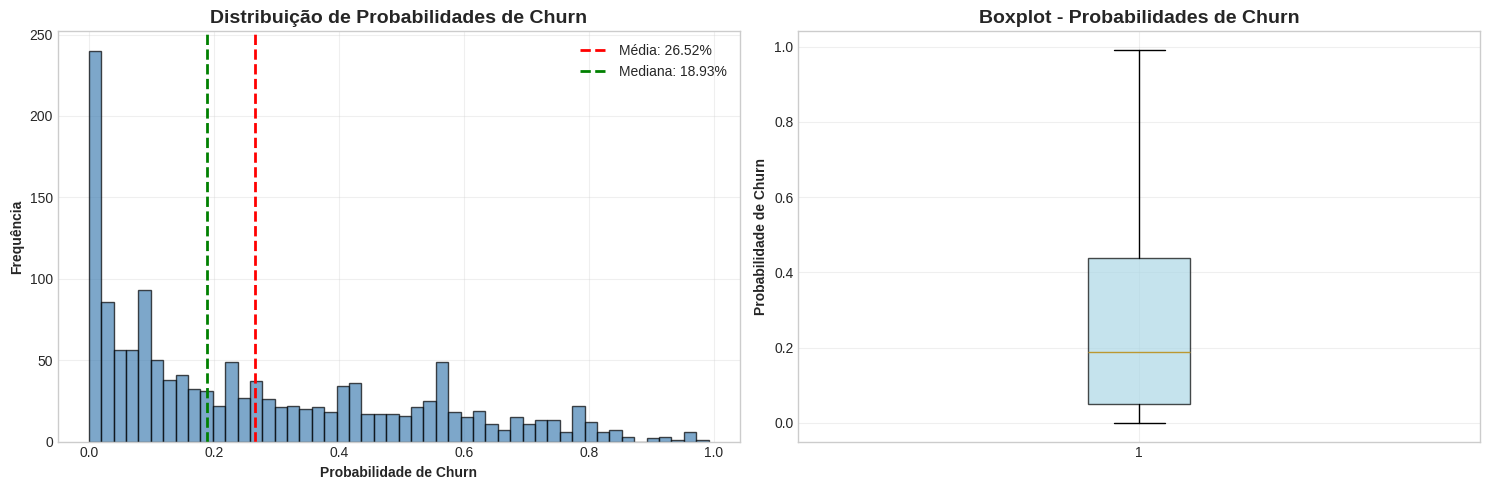

In [7]:
# Predições
predictions = model.predict(X_test)
probabilities = model.predict_proba(X_test)[:, 1]

print(f"Predições geradas para {len(predictions):,} clientes")

Predições geradas para 1,409 clientes


In [8]:
# DISTRIBUIÇÃO DE PROBABILIDADES

print(f"   • Média: {probabilities.mean():.2%}")
print(f"   • Mediana: {np.median(probabilities):.2%}")
print(f"   • Min: {probabilities.min():.2%}")
print(f"   • Max: {probabilities.max():.2%}")
print(f"   • Desvio Padrão: {probabilities.std():.2%}")

   • Média: 26.52%
   • Mediana: 18.93%
   • Min: 0.00%
   • Max: 99.13%
   • Desvio Padrão: 24.66%


In [9]:
# Distribuição por faixas
print(f"\nDistribuição por Faixa:")
faixas = [
    ("< 10%", probabilities < 0.10),
    ("10-20%", (probabilities >= 0.10) & (probabilities < 0.20)),
    ("20-30%", (probabilities >= 0.20) & (probabilities < 0.30)),
    ("30-50%", (probabilities >= 0.30) & (probabilities < 0.50)),
    ("50-70%", (probabilities >= 0.50) & (probabilities < 0.70)),
    ("> 70%", probabilities >= 0.70)
]

for label, mask in faixas:
    count = mask.sum()
    pct = mask.mean() * 100
    print(f"   • {label}: {count:,} ({pct:.1f}%)")


Distribuição por Faixa:
   • < 10%: 537 (38.1%)
   • 10-20%: 186 (13.2%)
   • 20-30%: 167 (11.9%)
   • 30-50%: 221 (15.7%)
   • 50-70%: 193 (13.7%)
   • > 70%: 105 (7.5%)


In [10]:
# Criar DataFrame principal
df = X_test.copy()
df['Churn_Probability'] = probabilities
df['Predicted_Churn'] = predictions
df['Actual_Churn'] = y_test.values

In [11]:
# Adicionar informações dos dados originais (MonthlyCharges, tenure, etc.)
# Assumindo que os índices estão alinhados

if len(df) == len(df_original):
    df['customerID'] = df_original['customerID'].values
    df['MonthlyCharges'] = df_original['MonthlyCharges'].values
    df['tenure'] = df_original['tenure'].values
    df['TotalCharges'] = df_original['TotalCharges'].values
    df['Contract'] = df_original['Contract'].values
else:
    # Se não estiver alinhado, usar índices do teste
    test_indices = y_test.index
    df['customerID'] = df_original.loc[test_indices, 'customerID'].values
    df['MonthlyCharges'] = df_original.loc[test_indices, 'MonthlyCharges'].values
    df['tenure'] = df_original.loc[test_indices, 'tenure'].values
    df['TotalCharges'] = df_original.loc[test_indices, 'TotalCharges'].values
    df['Contract'] = df_original.loc[test_indices, 'Contract'].values

print(f"\nDataFrame principal criado: {df.shape}")


DataFrame principal criado: (1409, 69)


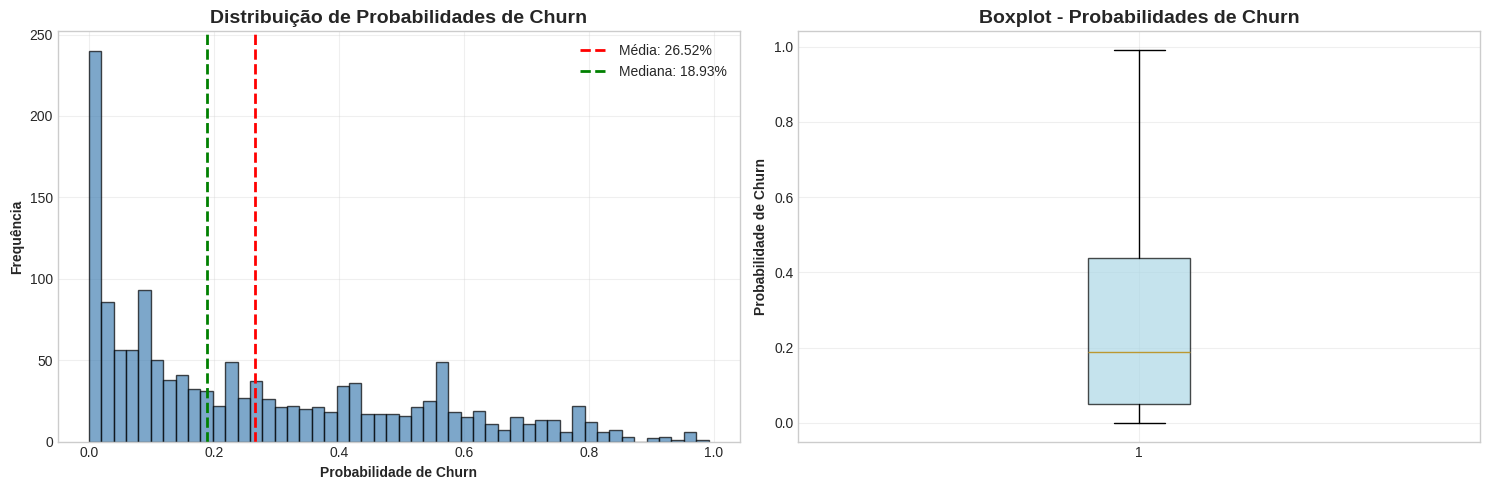

In [12]:
# Visualização
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histograma
axes[0].hist(probabilities, bins=50, color='steelblue', edgecolor='black', alpha=0.7)
axes[0].axvline(probabilities.mean(), color='red', linestyle='--', linewidth=2,
                label=f'Média: {probabilities.mean():.2%}')
axes[0].axvline(np.median(probabilities), color='green', linestyle='--', linewidth=2,
                label=f'Mediana: {np.median(probabilities):.2%}')
axes[0].set_xlabel('Probabilidade de Churn', fontweight='bold')
axes[0].set_ylabel('Frequência', fontweight='bold')
axes[0].set_title('Distribuição de Probabilidades de Churn', fontweight='bold', fontsize=14)
axes[0].legend()
axes[0].grid(alpha=0.3)

# Boxplot
axes[1].boxplot(probabilities, vert=True, patch_artist=True,
                boxprops=dict(facecolor='lightblue', alpha=0.7))
axes[1].set_ylabel('Probabilidade de Churn', fontweight='bold')
axes[1].set_title('Boxplot - Probabilidades de Churn', fontweight='bold', fontsize=14)
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Segmentação de Clientes por Risco

---


DISTRIBUIÇÃO POR NÍVEL DE RISCO:

**CRÍTICO:**

    • Quantidade: 140 (9.9%)
    • Prob. Média: 76.17%

**ALTO:**

    • Quantidade: 211 (15.0%)
    • Prob. Média: 54.13%

**MÉDIO:**

    • Quantidade: 353 (25.1%)
    • Prob. Média: 30.78%

**BAIXO:**

    • Quantidade: 705 (50.0%)
    • Prob. Média: 6.26%


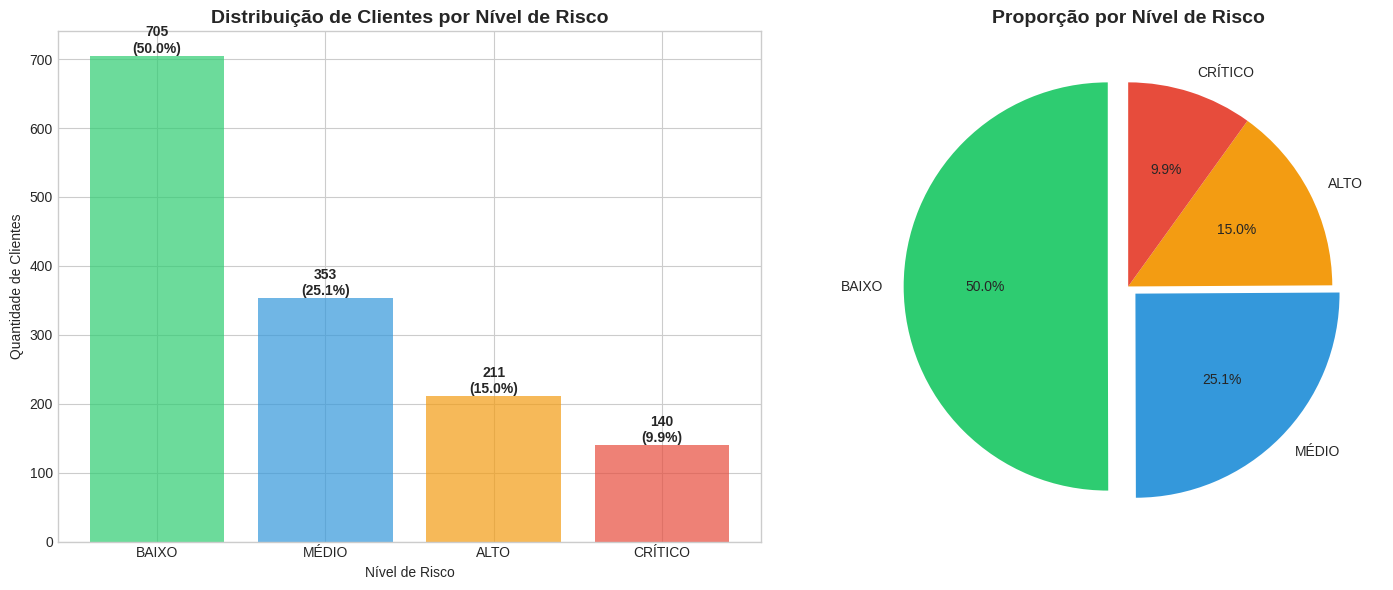

In [13]:
# Calcular percentis
percentiles = df['Churn_Probability'].quantile([0.50, 0.75, 0.90])

print(f"\nPercentis calculados:")
print(f"   • P50 (Mediana): {percentiles[0.50]:.2%}")
print(f"   • P75: {percentiles[0.75]:.2%}")
print(f"   • P90: {percentiles[0.90]:.2%}")


Percentis calculados:
   • P50 (Mediana): 18.93%
   • P75: 43.93%
   • P90: 62.64%


In [14]:
# Segmentação por percentis
df['Risk_Level'] = pd.cut(
    df['Churn_Probability'],
    bins=[0, percentiles[0.50], percentiles[0.75], percentiles[0.90], 1],
    labels=['BAIXO', 'MÉDIO', 'ALTO', 'CRÍTICO'],
    include_lowest=True
)

In [16]:
# Estatísticas por segmento
risk_distribution = df['Risk_Level'].value_counts().sort_index()

print("\nDISTRIBUIÇÃO POR NÍVEL DE RISCO:")
print("="*60)

for level in ['CRÍTICO', 'ALTO', 'MÉDIO', 'BAIXO']:
    count = risk_distribution.get(level, 0)
    pct = count / len(df) * 100
    avg_prob = df[df['Risk_Level'] == level]['Churn_Probability'].mean()

    print(f"\n{level}:")
    print(f"   • Quantidade: {count:,} ({pct:.1f}%)")
    print(f"   • Prob. Média: {avg_prob:.2%}")


DISTRIBUIÇÃO POR NÍVEL DE RISCO:

CRÍTICO:
   • Quantidade: 140 (9.9%)
   • Prob. Média: 76.17%

ALTO:
   • Quantidade: 211 (15.0%)
   • Prob. Média: 54.13%

MÉDIO:
   • Quantidade: 353 (25.1%)
   • Prob. Média: 30.78%

BAIXO:
   • Quantidade: 705 (50.0%)
   • Prob. Média: 6.26%


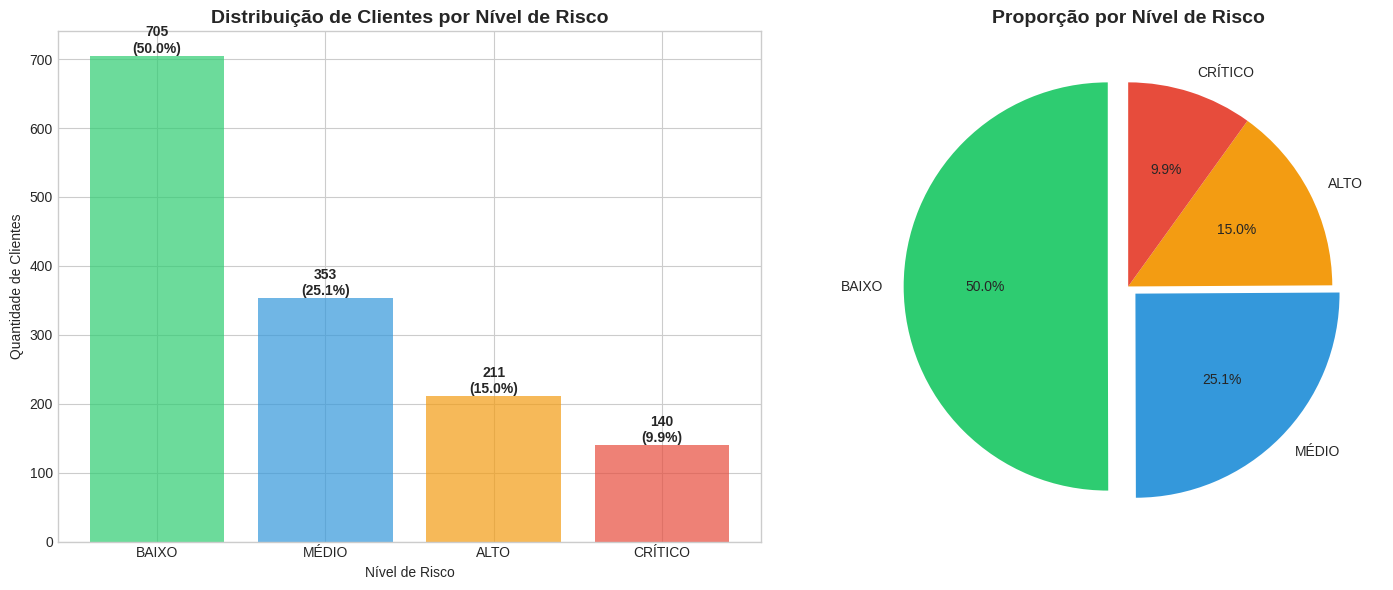

In [17]:
# Visualização
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Gráfico de barras
colors_map = {'CRÍTICO': '#e74c3c', 'ALTO': '#f39c12', 'MÉDIO': '#3498db', 'BAIXO': '#2ecc71'}
colors = [colors_map[level] for level in risk_distribution.index]

axes[0].bar(risk_distribution.index, risk_distribution.values, color=colors, alpha=0.7)
axes[0].set_title('Distribuição de Clientes por Nível de Risco', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Quantidade de Clientes')
axes[0].set_xlabel('Nível de Risco')

# Adicionar valores
for i, (level, count) in enumerate(risk_distribution.items()):
    axes[0].text(i, count, f'{count:,}\n({count/len(df)*100:.1f}%)',
                ha='center', va='bottom', fontweight='bold')

# Gráfico de pizza
axes[1].pie(risk_distribution.values, labels=risk_distribution.index, autopct='%1.1f%%',
            colors=colors, startangle=90, explode=(0.1, 0.05, 0, 0))
axes[1].set_title('Proporção por Nível de Risco', fontweight='bold', fontsize=14)

plt.tight_layout()
plt.show()

## 5. Sistema de Recomendação de Ações

---

PLAYBOOK DE RETENÇÃO:

==================================

**CRÍTICO - Alto Risco de Churn**:

==================================

    Prioridade: MÁXIMA
    Custo médio: $ 150
    Taxa de conversão: 40%
    ROI estimado: 4.5x

**Ações:**

* Contato imediato do gerente de contas
* Desconto de 25-30% por 6 meses
* Upgrade gratuito de serviço
* Suporte VIP dedicado
* Oferta personalizada baseada em histórico

==================================

**ALTO - Risco Elevado**:

==================================

    Prioridade: ALTA
    Custo médio: $ 80
    Taxa de conversão: 35%
    ROI estimado: 3.5x

**Ações:**

* Campanha de reengajamento personalizada
* Desconto de 15-20% por 3 meses
* Pacote de serviços complementares
* Oferta de contrato de 1-2 anos com benefícios
* Acesso antecipado a novos serviços


==================================

**MÉDIO - Risco Moderado**:

==================================

    Prioridade: MÉDIA
    Custo médio: $ 30
    Taxa de conversão: 25%
    ROI estimado: 2.5x

**Ações**:

* Newsletter com dicas e promoções
* Programa de fidelidade com pontos
* Brindes e ofertas sazonais
* Acesso a beta de novos produtos
* Email marketing segmentado

==================================

**BAIXO - Risco Mínimo**:

==================================

    Prioridade: BAIXA
    Custo médio: $ 10
    Taxa de conversão: 15%
    ROI estimado: 1.8x

**Ações**:

* Manutenção de relacionamento padrão
* Reconhecimento de lealdade
* Programa de indicação com recompensas
* Notificações sobre novos produtos
* Pesquisa de satisfação periódica

In [18]:
# Definir playbook de ações
action_mapping = {
    'CRÍTICO': {
        'name': 'CRÍTICO - Alto Risco de Churn',
        'actions': [
            'Contato imediato do gerente de contas',
            'Desconto de 25-30% por 6 meses',
            'Upgrade gratuito de serviço',
            'Suporte VIP dedicado',
            'Oferta personalizada baseada em histórico'
        ],
        'priority': 'MÁXIMA',
        'estimated_cost': 150,
        'conversion_rate': 0.40,
        'estimated_roi': '4.5x'
    },
    'ALTO': {
        'name': 'ALTO - Risco Elevado',
        'actions': [
            'Campanha de reengajamento personalizada',
            'Desconto de 15-20% por 3 meses',
            'Pacote de serviços complementares',
            'Oferta de contrato de 1-2 anos com benefícios',
            'Acesso antecipado a novos serviços'
        ],
        'priority': 'ALTA',
        'estimated_cost': 80,
        'conversion_rate': 0.35,
        'estimated_roi': '3.5x'
    },
    'MÉDIO': {
        'name': 'MÉDIO - Risco Moderado',
        'actions': [
            'Newsletter com dicas e promoções',
            'Programa de fidelidade com pontos',
            'Brindes e ofertas sazonais',
            'Acesso a beta de novos produtos',
            'Email marketing segmentado'
        ],
        'priority': 'MÉDIA',
        'estimated_cost': 30,
        'conversion_rate': 0.25,
        'estimated_roi': '2.5x'
    },
    'BAIXO': {
        'name': 'BAIXO - Risco Mínimo',
        'actions': [
            'Manutenção de relacionamento padrão',
            'Reconhecimento de lealdade',
            'Programa de indicação com recompensas',
            'Notificações sobre novos produtos',
            'Pesquisa de satisfação periódica'
        ],
        'priority': 'BAIXA',
        'estimated_cost': 10,
        'conversion_rate': 0.15,
        'estimated_roi': '1.8x'
    }
}

In [19]:
# Atribuir ações recomendadas
df['Recommended_Action'] = df['Risk_Level'].map(
    lambda x: action_mapping[x]['actions'][0]
)

df['Action_Cost'] = df['Risk_Level'].map(
    lambda x: action_mapping[x]['estimated_cost']
)

df['Conversion_Rate'] = df['Risk_Level'].map(
    lambda x: action_mapping[x]['conversion_rate']
)

print("\nAções recomendadas atribuídas a todos os clientes")


Ações recomendadas atribuídas a todos os clientes


In [20]:
# Exibir playbook
print("\nPLAYBOOK DE RETENÇÃO:")
print("="*80)

for level in ['CRÍTICO', 'ALTO', 'MÉDIO', 'BAIXO']:
    if level in action_mapping:
        info = action_mapping[level]
        print(f"\n{'='*70}")
        print(f"{info['name']}")
        print(f"{'='*70}")
        print(f"Prioridade: {info['priority']}")
        print(f"Custo médio: $ {info['estimated_cost']}")
        print(f"Taxa de conversão: {info['conversion_rate']*100:.0f}%")
        print(f"ROI estimado: {info['estimated_roi']}")
        print(f"\nAções:")
        for action in info['actions']:
            print(f"  {action}")


PLAYBOOK DE RETENÇÃO:

CRÍTICO - Alto Risco de Churn
Prioridade: MÁXIMA
Custo médio: R$ 150
Taxa de conversão: 40%
ROI estimado: 4.5x

Ações:
  Contato imediato do gerente de contas
  Desconto de 25-30% por 6 meses
  Upgrade gratuito de serviço
  Suporte VIP dedicado
  Oferta personalizada baseada em histórico

ALTO - Risco Elevado
Prioridade: ALTA
Custo médio: R$ 80
Taxa de conversão: 35%
ROI estimado: 3.5x

Ações:
  Campanha de reengajamento personalizada
  Desconto de 15-20% por 3 meses
  Pacote de serviços complementares
  Oferta de contrato de 1-2 anos com benefícios
  Acesso antecipado a novos serviços

MÉDIO - Risco Moderado
Prioridade: MÉDIA
Custo médio: R$ 30
Taxa de conversão: 25%
ROI estimado: 2.5x

Ações:
  Newsletter com dicas e promoções
  Programa de fidelidade com pontos
  Brindes e ofertas sazonais
  Acesso a beta de novos produtos
  Email marketing segmentado

BAIXO - Risco Mínimo
Prioridade: BAIXA
Custo médio: R$ 10
Taxa de conversão: 15%
ROI estimado: 1.8x

Ações:


## 6. Cálculo de CLV e Impacto Financeiro

----

## CÁLCULO DE CLV (Customer Lifetime Value)



*** *Medir o total de receita ou lucro líquido que um cliente gera para a empresa durante todo o relacionamento*

============================

**RESUMO FINANCEIRO GERA**L:

============================

    Total de Clientes: 1,409
    CLV Total da Base: $ 6,649,756.46

    Receita em Risco: $ 858,934.71
    Custo Total de Ações: $ 55,520.00
    Receita Recuperável: $ 218,088.83

* **Lucro Líquido Estimado**: $ 162,568.83
* **ROI Geral**: 292.8%


In [26]:
# Calcular CLV
# CLV = Receita Mensal × Tenure Esperado
# Tenure Esperado = 1 / Taxa de Churn (simplificado)

df['CLV'] = df['MonthlyCharges'] * (1 / df['Churn_Probability'].clip(lower=0.01)) * 12

# Limitar CLV a valores razoáveis (máximo 10 anos)
df['CLV'] = df['CLV'].clip(upper=df['MonthlyCharges'] * 120)

print(f"\nCLV Calculado:")
print(f"   • CLV médio: $ {df['CLV'].mean():,.2f}")
print(f"   • CLV mediano: $ {df['CLV'].median():,.2f}")
print(f"   • CLV mínimo: $ {df['CLV'].min():,.2f}")
print(f"   • CLV máximo: $ {df['CLV'].max():,.2f}")


CLV Calculado:
   • CLV médio: $ 4,719.49
   • CLV mediano: $ 3,066.00
   • CLV mínimo: $ 243.44
   • CLV máximo: $ 13,950.00


In [92]:
# Calcular métricas financeiras
df['Revenue_at_Risk'] = df['Churn_Probability'] * df['CLV']
df['Expected_Retained'] = df['Conversion_Rate'].astype(float)
df['Revenue_Recovered'] = df['Revenue_at_Risk'] * df['Expected_Retained']
df['Action_Cost'] = df['Risk_Level'].map(
    lambda x: action_mapping[x]['estimated_cost']
).astype(float) # Explicitly cast to float
df['Net_Profit'] = df['Revenue_Recovered'] - df['Action_Cost']
df['Expected_ROI'] = (df['Net_Profit'] / df['Action_Cost'] * 100).fillna(0)

# Resumo geral
total_customers = len(df)
total_clv = df['CLV'].sum().item()
total_revenue_at_risk = df['Revenue_at_Risk'].sum().item()
total_action_cost = df['Action_Cost'].sum().item()
total_revenue_recovered = df['Revenue_Recovered'].sum().item()
net_profit = df['Net_Profit'].sum().item()
overall_roi = (net_profit / total_action_cost * 100) if total_action_cost > 0 else 0

print(f"\nRESUMO FINANCEIRO GERAL:")
print(f"{'='*70}")
print(f"Total de Clientes: {total_customers:,}")
print(f"CLV Total da Base: R$ {total_clv:,.2f}")
print(f"\nReceita em Risco: R$ {total_revenue_at_risk:,.2f}")
print(f"Custo Total de Ações: R$ {total_action_cost:,.2f}")
print(f"Receita Recuperável: R$ {total_revenue_recovered:,.2f}")
print(f"\nLucro Líquido Estimado: R$ {net_profit:,.2f}")
print(f"ROI Geral: {overall_roi:.1f}%")
print(f"{'='*70}")


RESUMO FINANCEIRO GERAL:
Total de Clientes: 1,409
CLV Total da Base: R$ 6,649,756.46

Receita em Risco: R$ 858,934.71
Custo Total de Ações: R$ 55,520.00
Receita Recuperável: R$ 218,088.83

Lucro Líquido Estimado: R$ 162,568.83
ROI Geral: 292.8%


## IMPACTO FINANCEIRO POR SEGMENTO

----

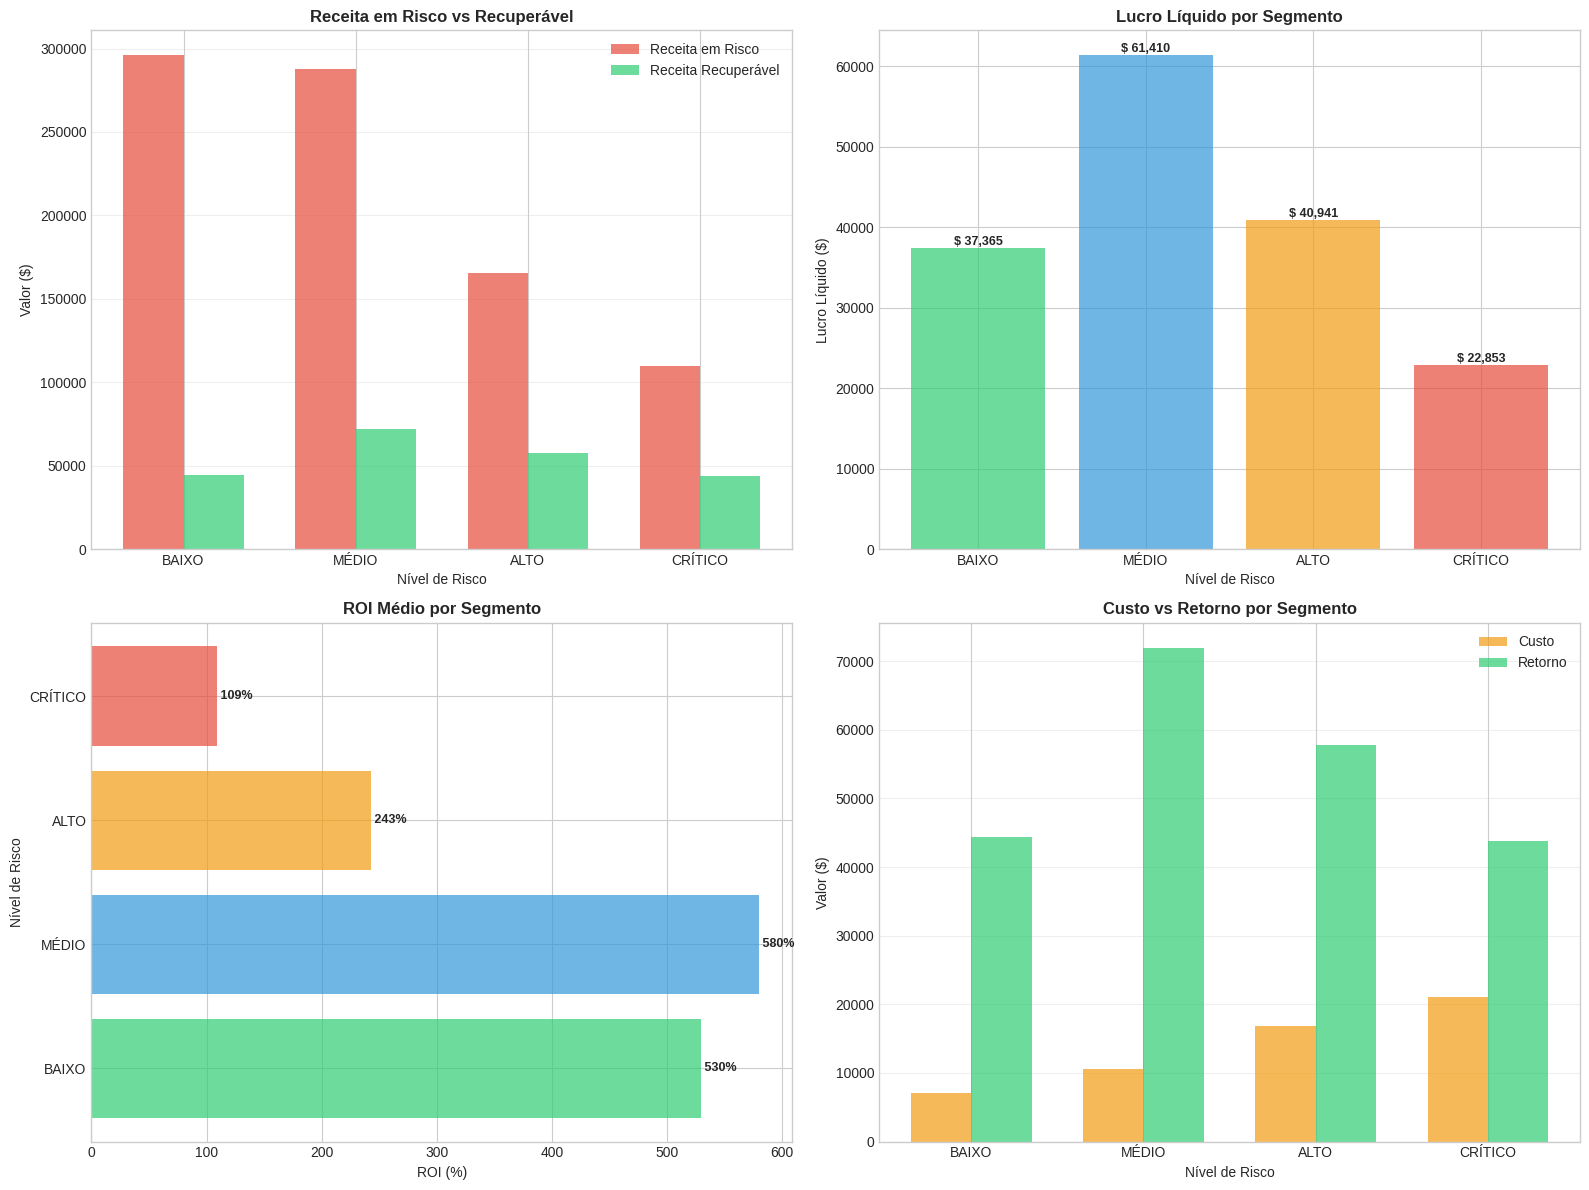



In [31]:
# Por segmento
financial_by_risk = df.groupby('Risk_Level').agg({
    'customerID': 'count',
    'CLV': 'sum',
    'Revenue_at_Risk': 'sum',
    'Action_Cost': 'sum',
    'Revenue_Recovered': 'sum',
    'Net_Profit': 'sum',
    'Expected_ROI': 'mean'
}).round(2)

financial_by_risk.columns = [
    'Clientes', 'CLV Total', 'Receita em Risco',
    'Custo Total', 'Receita Recuperável', 'Lucro Líquido', 'ROI Médio (%)'
]

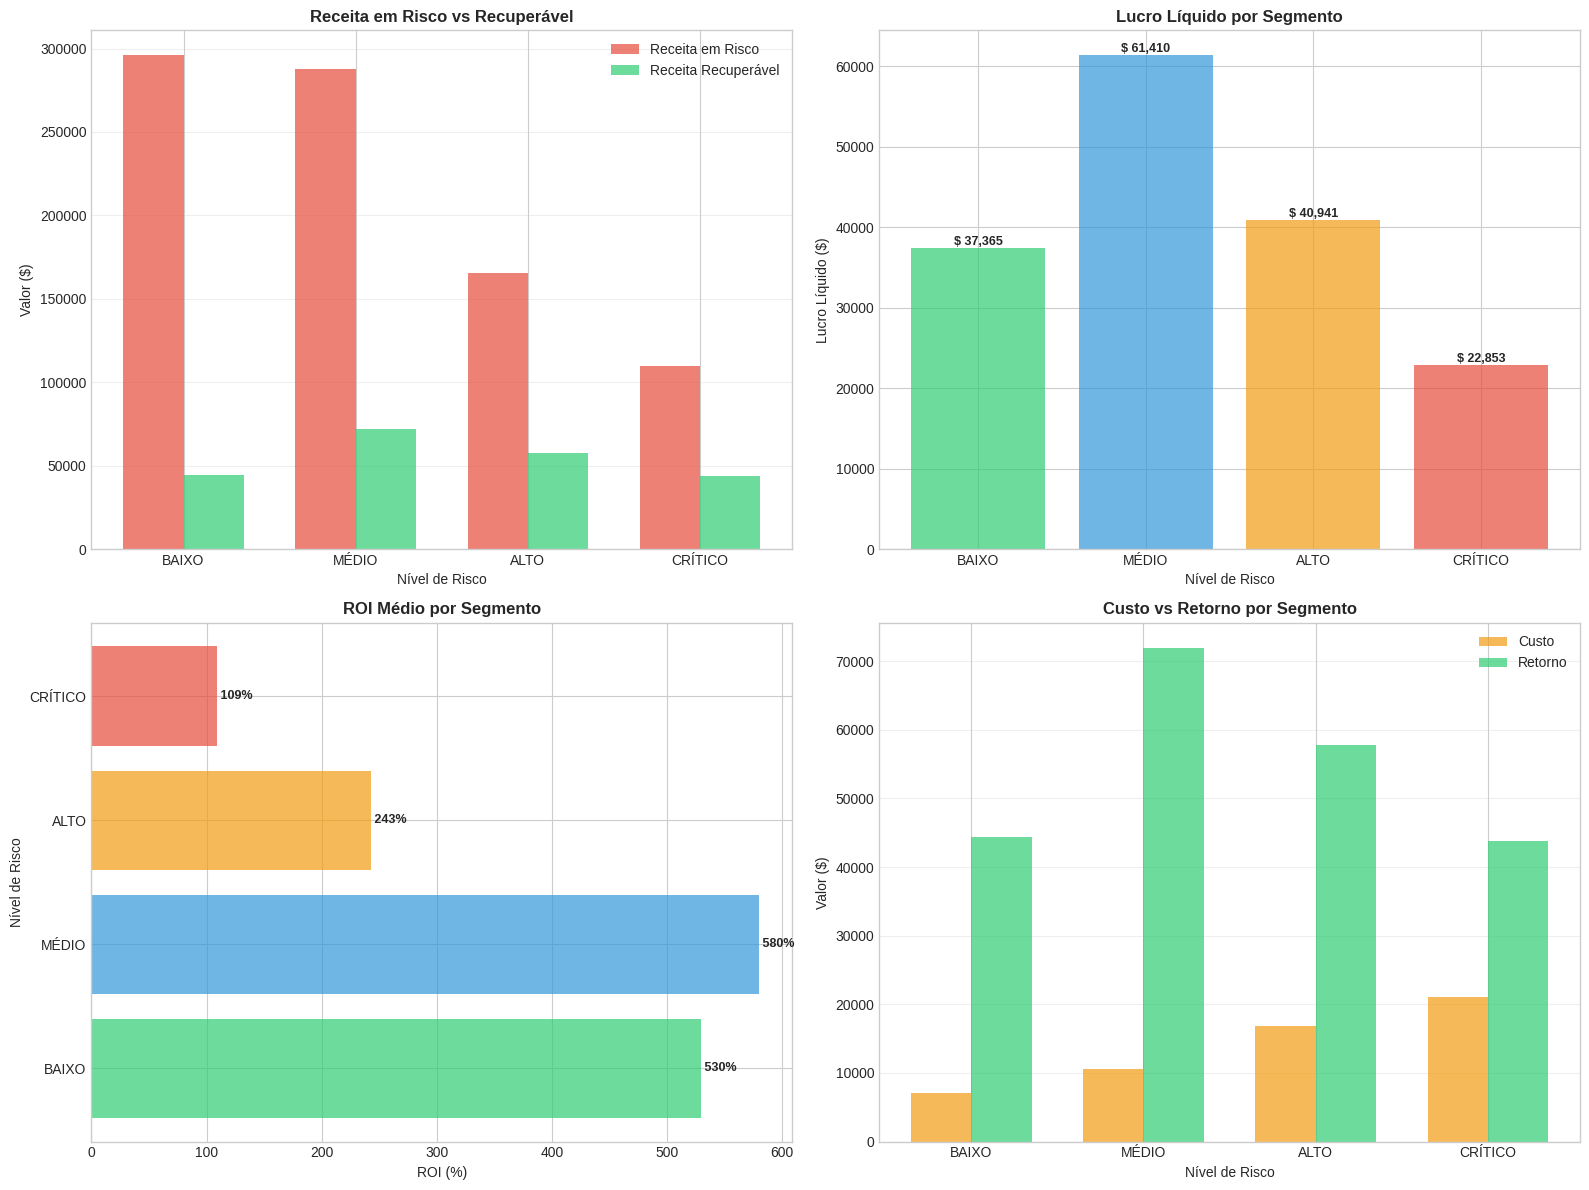

In [47]:
# Visualização
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Receita em Risco vs Recuperável
x = range(len(financial_by_risk))
width = 0.35

axes[0, 0].bar([i - width/2 for i in x], financial_by_risk['Receita em Risco'],
               width, label='Receita em Risco', color='#e74c3c', alpha=0.7)
axes[0, 0].bar([i + width/2 for i in x], financial_by_risk['Receita Recuperável'],
               width, label='Receita Recuperável', color='#2ecc71', alpha=0.7)
axes[0, 0].set_xlabel('Nível de Risco')
axes[0, 0].set_ylabel('Valor ($)')
axes[0, 0].set_title('Receita em Risco vs Recuperável', fontweight='bold', fontsize=12)
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(financial_by_risk.index)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3, axis='y')

# 2. Lucro Líquido por Segmento
colors = [colors_map[level] for level in financial_by_risk.index]
axes[0, 1].bar(financial_by_risk.index, financial_by_risk['Lucro Líquido'],
               color=colors, alpha=0.7)
axes[0, 1].set_title('Lucro Líquido por Segmento', fontweight='bold', fontsize=12)
axes[0, 1].set_ylabel('Lucro Líquido ($)')
axes[0, 1].set_xlabel('Nível de Risco')

for i, (level, row) in enumerate(financial_by_risk.iterrows()):
    axes[0, 1].text(i, row['Lucro Líquido'], f"$ {row['Lucro Líquido']:,.0f}",
                    ha='center', va='bottom', fontweight='bold', fontsize=9)

# 3. ROI por Segmento
axes[1, 0].barh(financial_by_risk.index, financial_by_risk['ROI Médio (%)'],
                color=colors, alpha=0.7)
axes[1, 0].set_title('ROI Médio por Segmento', fontweight='bold', fontsize=12)
axes[1, 0].set_xlabel('ROI (%)')
axes[1, 0].set_ylabel('Nível de Risco')

for i, (level, row) in enumerate(financial_by_risk.iterrows()):
    axes[1, 0].text(row['ROI Médio (%)'], i, f" {row['ROI Médio (%)']:.0f}%",
                    va='center', fontweight='bold', fontsize=9)

# 4. Custo vs Retorno
axes[1, 1].bar([i - width/2 for i in x], financial_by_risk['Custo Total'],
               width, label='Custo', color='#f39c12', alpha=0.7)
axes[1, 1].bar([i + width/2 for i in x], financial_by_risk['Receita Recuperável'],
               width, label='Retorno', color='#2ecc71', alpha=0.7)
axes[1, 1].set_xlabel('Nível de Risco')
axes[1, 1].set_ylabel('Valor ($)')
axes[1, 1].set_title('Custo vs Retorno por Segmento', fontweight='bold', fontsize=12)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(financial_by_risk.index)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

In [48]:
# Fechar figuras existentes
for fig_num in plt.get_fignums():
    plt.close(fig_num)

## 7. Simulação de Cenários


---

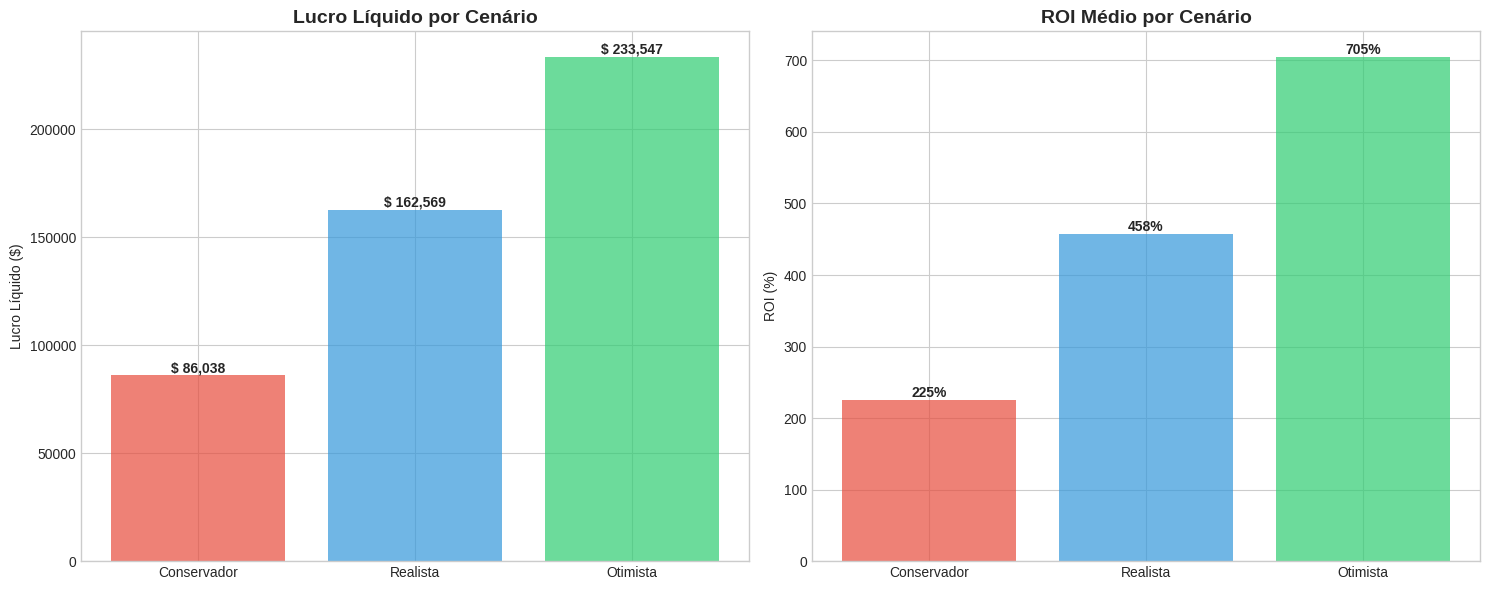

In [49]:
# Definir cenários
scenarios = {
    'Conservador': {
        'conversion_multiplier': 0.7,
        'cost_multiplier': 1.2,
        'description': 'Cenário pessimista com menor conversão e maior custo'
    },
    'Realista': {
        'conversion_multiplier': 1.0,
        'cost_multiplier': 1.0,
        'description': 'Cenário base com taxas esperadas'
    },
    'Otimista': {
        'conversion_multiplier': 1.3,
        'cost_multiplier': 0.9,
        'description': 'Cenário otimista com melhor conversão e menor custo'
    }
}

scenario_results = []

In [50]:
for scenario_name, params in scenarios.items():
    # Ensure 'Conversion_Rate' is numeric before multiplication
    adjusted_conversion = df['Conversion_Rate'].astype(float) * params['conversion_multiplier']
    # Ensure 'Action_Cost' is numeric before multiplication
    adjusted_cost = df['Action_Cost'].astype(float) * params['cost_multiplier']

    revenue_recovered = df['Revenue_at_Risk'] * adjusted_conversion
    net_profit = revenue_recovered - adjusted_cost
    roi = (net_profit / adjusted_cost * 100).mean()

    scenario_results.append({
        'Cenário': scenario_name,
        'Descrição': params['description'],
        'Receita Recuperada': revenue_recovered.sum(),
        'Custo Total': adjusted_cost.sum(),
        'Lucro Líquido': net_profit.sum(),
        'ROI Médio (%)': roi
    })

scenario_df = pd.DataFrame(scenario_results)


RESULTADOS DA SIMULAÇÃO:


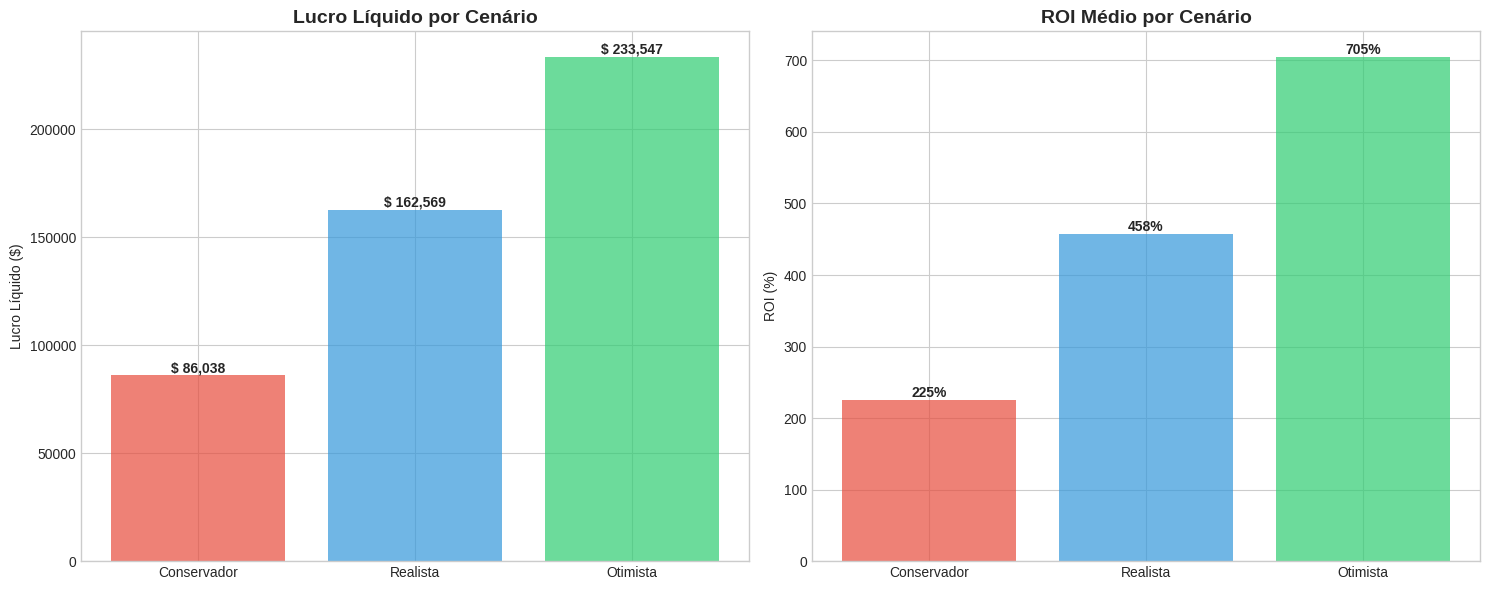

In [51]:
print(f"\nRESULTADOS DA SIMULAÇÃO:")
# display(scenario_df)

plt.close('all')  # Fecha TODAS as figuras anteriores

# Visualização
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

colors_scenario = ['#e74c3c', '#3498db', '#2ecc71']

# Lucro Líquido
axes[0].bar(scenario_df['Cenário'], scenario_df['Lucro Líquido'],
            color=colors_scenario, alpha=0.7)
axes[0].set_title('Lucro Líquido por Cenário', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Lucro Líquido ($)')

for i, row in scenario_df.iterrows():
    axes[0].text(i, row['Lucro Líquido'], f"$ {row['Lucro Líquido']:,.0f}",
                ha='center', va='bottom', fontweight='bold')

# ROI
axes[1].bar(scenario_df['Cenário'], scenario_df['ROI Médio (%)'],
            color=colors_scenario, alpha=0.7)
axes[1].set_title('ROI Médio por Cenário', fontweight='bold', fontsize=14)
axes[1].set_ylabel('ROI (%)')

for i, row in scenario_df.iterrows():
    axes[1].text(i, row['ROI Médio (%)'], f"{row['ROI Médio (%)']:.0f}%",
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

## 8. Priorização de Clientes

----

Fórmula do Score de priorização:

    60% Probabilidade + 40% CLV Normalizado


TOP 100 CLIENTES PRIORITÁRIOS:

    • Receita em Risco: R$ 81,312.00
    • Receita Recuperável: R$ 32,524.80
    • Custo Total: R$ 15,000.00
    • Lucro Esperado: R$ 17,524.80
    • ROI Médio: 117%

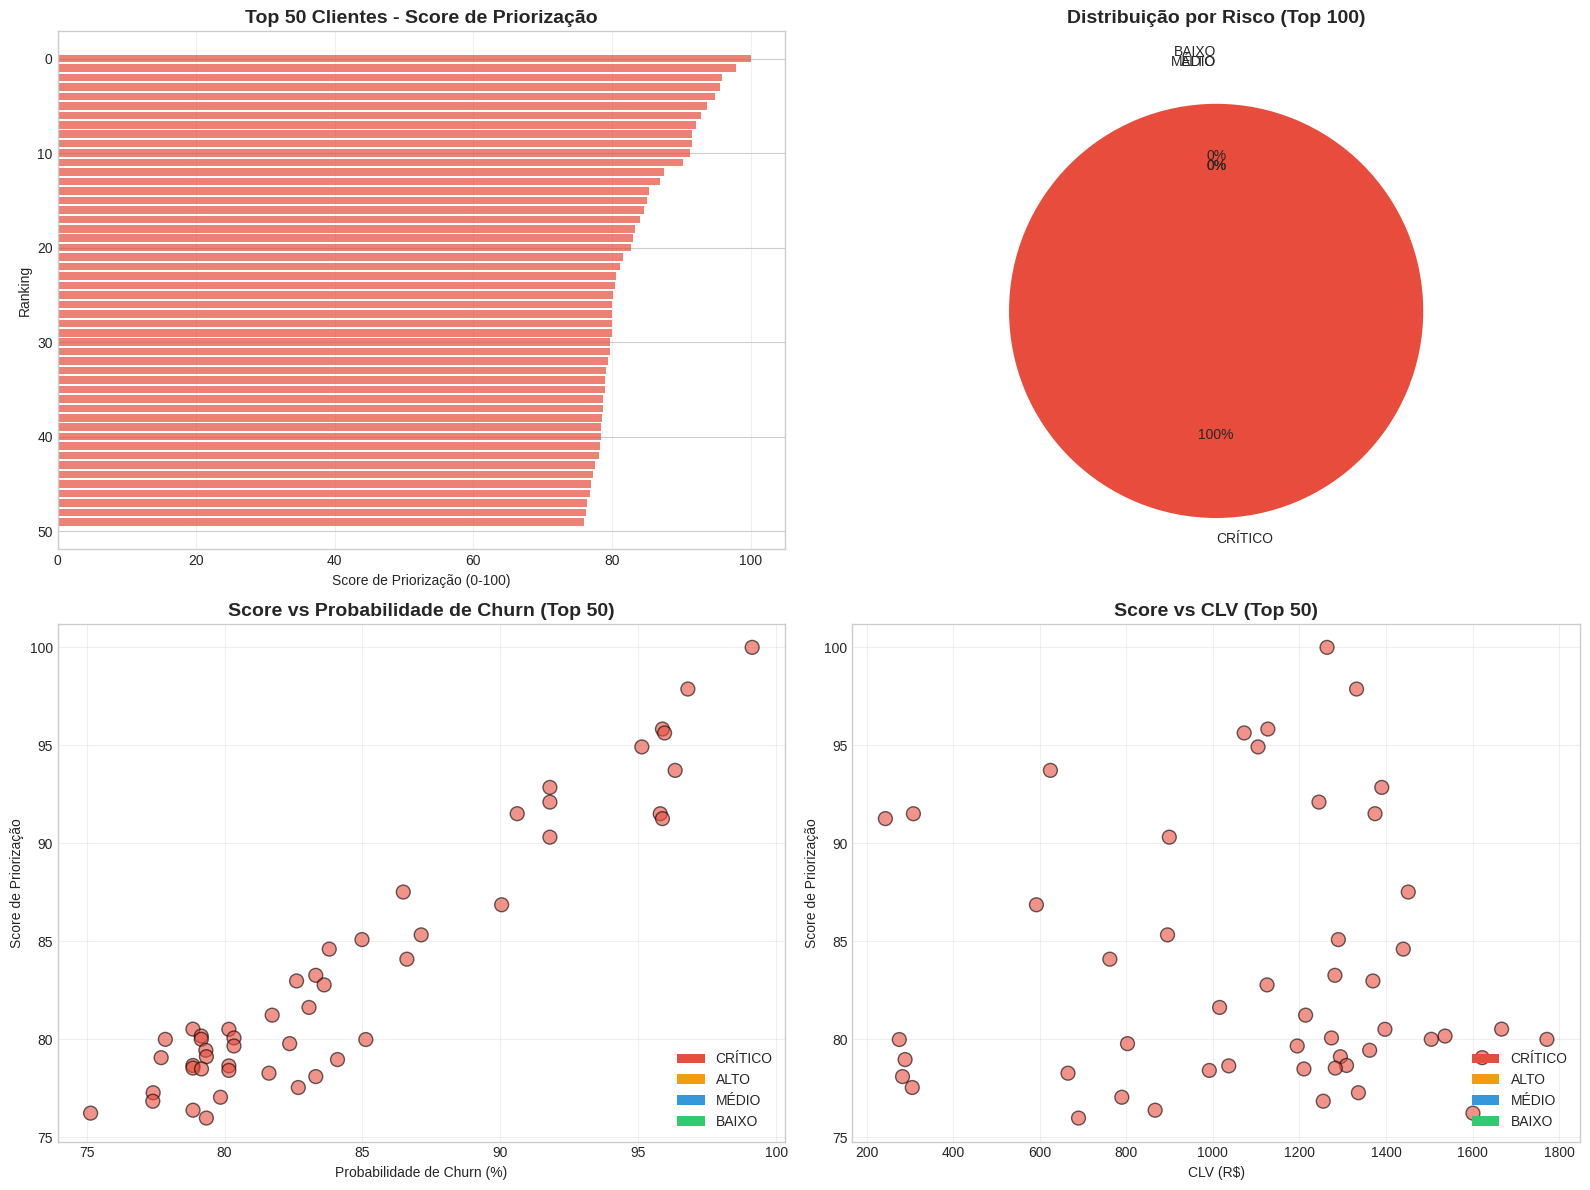


----


###Análise Detalhada do Top 20

---

Métricas Financeiras:

    • CLV Médio: R$ 1,053.39
    • CLV Total: R$ 21,067.87
    • Receita em Risco Total: R$ 19,054.20
    • Receita Recuperável: R$ 7,621.68
    • Lucro Líquido Esperado: R$ 4,621.68

Métricas de Risco:

    • Probabilidade Média de Churn: 91.09%
    • Probabilidade Mínima: 82.61%
    • Probabilidade Máxima: 99.13%

Métricas de Ação:

    • Custo Total de Ações: R$ 3,000.00
    • Custo Médio por Cliente:

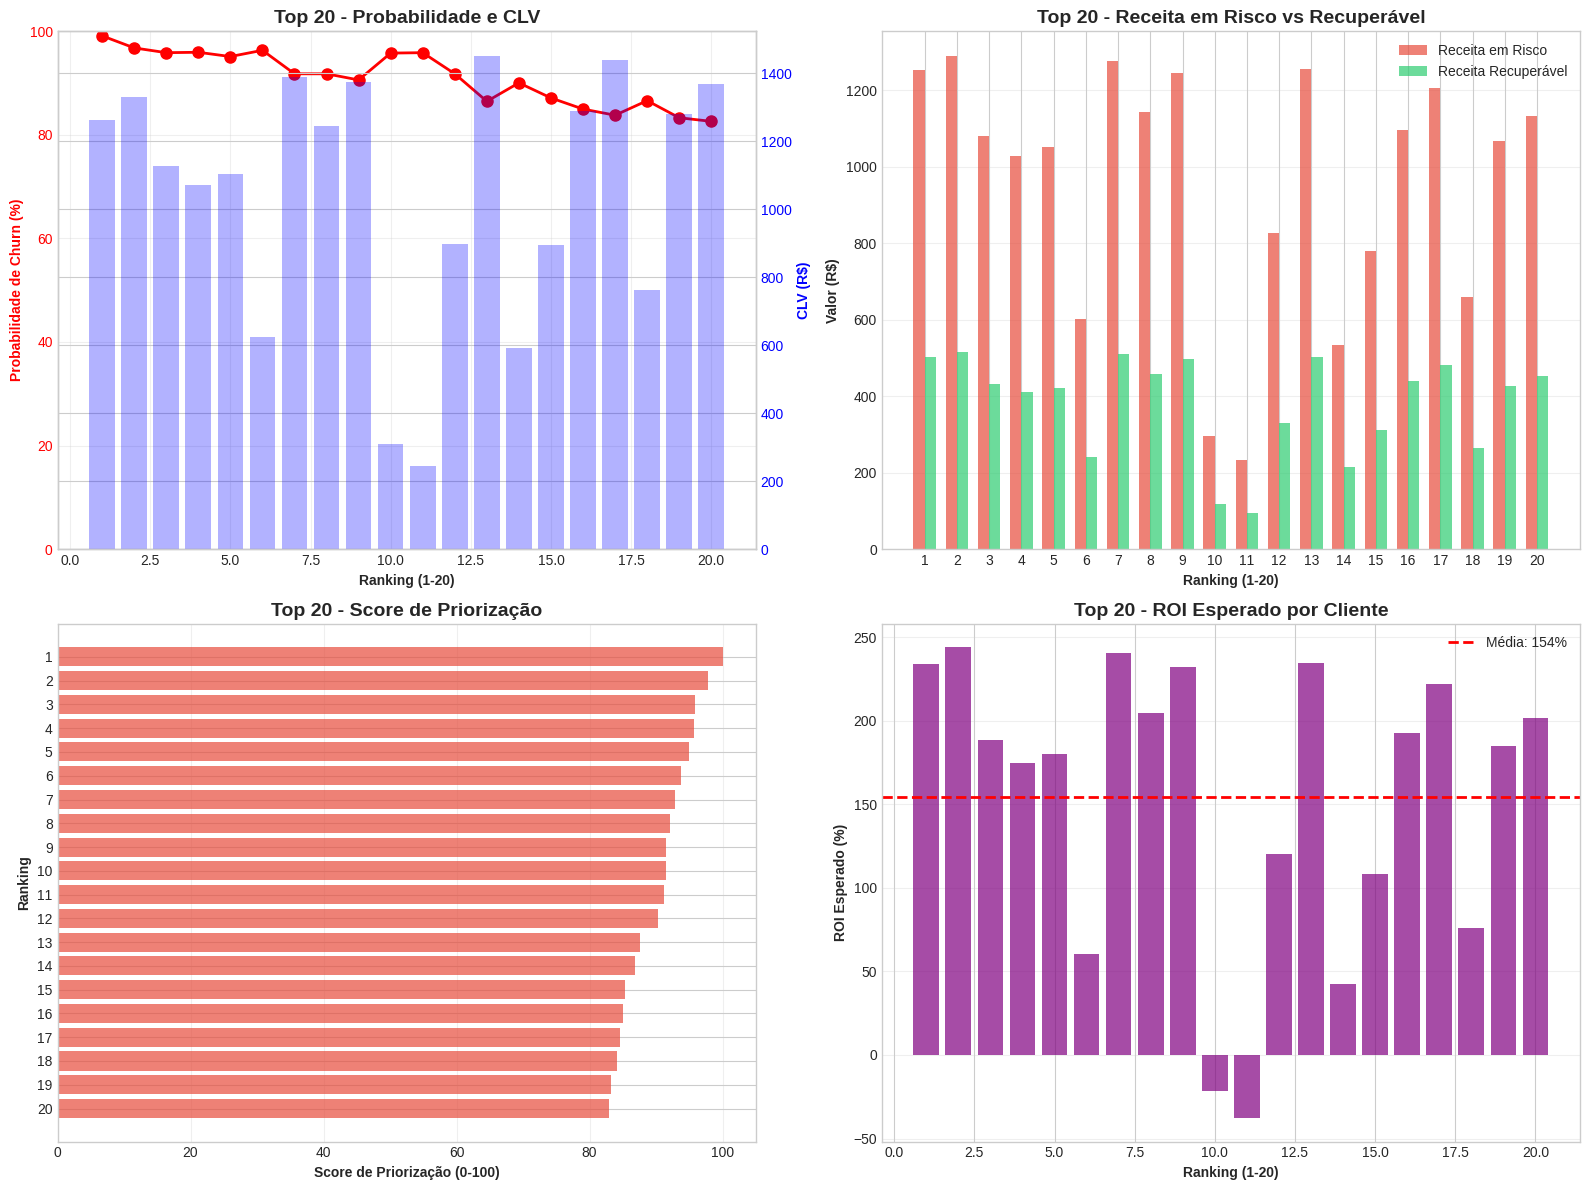

In [77]:
# Normalizar CLV (0-1)
clv_normalized = (df['CLV'] - df['CLV'].min()) / (df['CLV'].max() - df['CLV'].min())

# Score ponderado: 60% probabilidade + 40% CLV
df['Priority_Score'] = (df['Churn_Probability'] * 0.6) + (clv_normalized * 0.4)

# Normalizar para 0-100 (facilita interpretação)
df['Priority_Score_Normalized'] = (
    (df['Priority_Score'] - df['Priority_Score'].min()) /
    (df['Priority_Score'].max() - df['Priority_Score'].min()) * 100
)

print("Score de priorização calculado!")
print(f"\nFórmula: (Probabilidade × 0.6) + (CLV_Normalizado × 0.4)")
print(f"   • 60% peso na probabilidade (urgência)")
print(f"   • 40% peso no CLV (valor do cliente)")

Score de priorização calculado!

Fórmula: (Probabilidade × 0.6) + (CLV_Normalizado × 0.4)
   • 60% peso na probabilidade (urgência)
   • 40% peso no CLV (valor do cliente)


In [78]:
# Top 100 clientes prioritários
top_priority = df.nlargest(100, 'Priority_Score_Normalized')

print(f"\nTOP 100 CLIENTES PRIORITÁRIOS:")
print(f"   • Receita em Risco: R$ {top_priority['Revenue_at_Risk'].sum():,.2f}")
print(f"   • Receita Recuperável: R$ {top_priority['Revenue_Recovered'].sum():,.2f}")
print(f"   • Custo Total: R$ {top_priority['Action_Cost'].sum():,.2f}")
print(f"   • Lucro Esperado: R$ {top_priority['Net_Profit'].sum():,.2f}")
print(f"   • ROI Médio: {top_priority['Expected_ROI'].mean():.0f}%")


TOP 100 CLIENTES PRIORITÁRIOS:
   • Receita em Risco: R$ 81,312.00
   • Receita Recuperável: R$ 32,524.80
   • Custo Total: R$ 15,000.00
   • Lucro Esperado: R$ 17,524.80
   • ROI Médio: 117%


In [79]:
# Distribuição por risco dos top 100
top_risk_dist = top_priority['Risk_Level'].value_counts()

print(f"\nDistribuição por Risco (Top 100):")
for level in ['CRÍTICO', 'ALTO', 'MÉDIO', 'BAIXO']:
    count = top_risk_dist.get(level, 0)
    pct = count / 100 * 100
    print(f"   • {level}: {count} ({pct:.0f}%)")


Distribuição por Risco (Top 100):
   • CRÍTICO: 100 (100%)
   • ALTO: 0 (0%)
   • MÉDIO: 0 (0%)
   • BAIXO: 0 (0%)


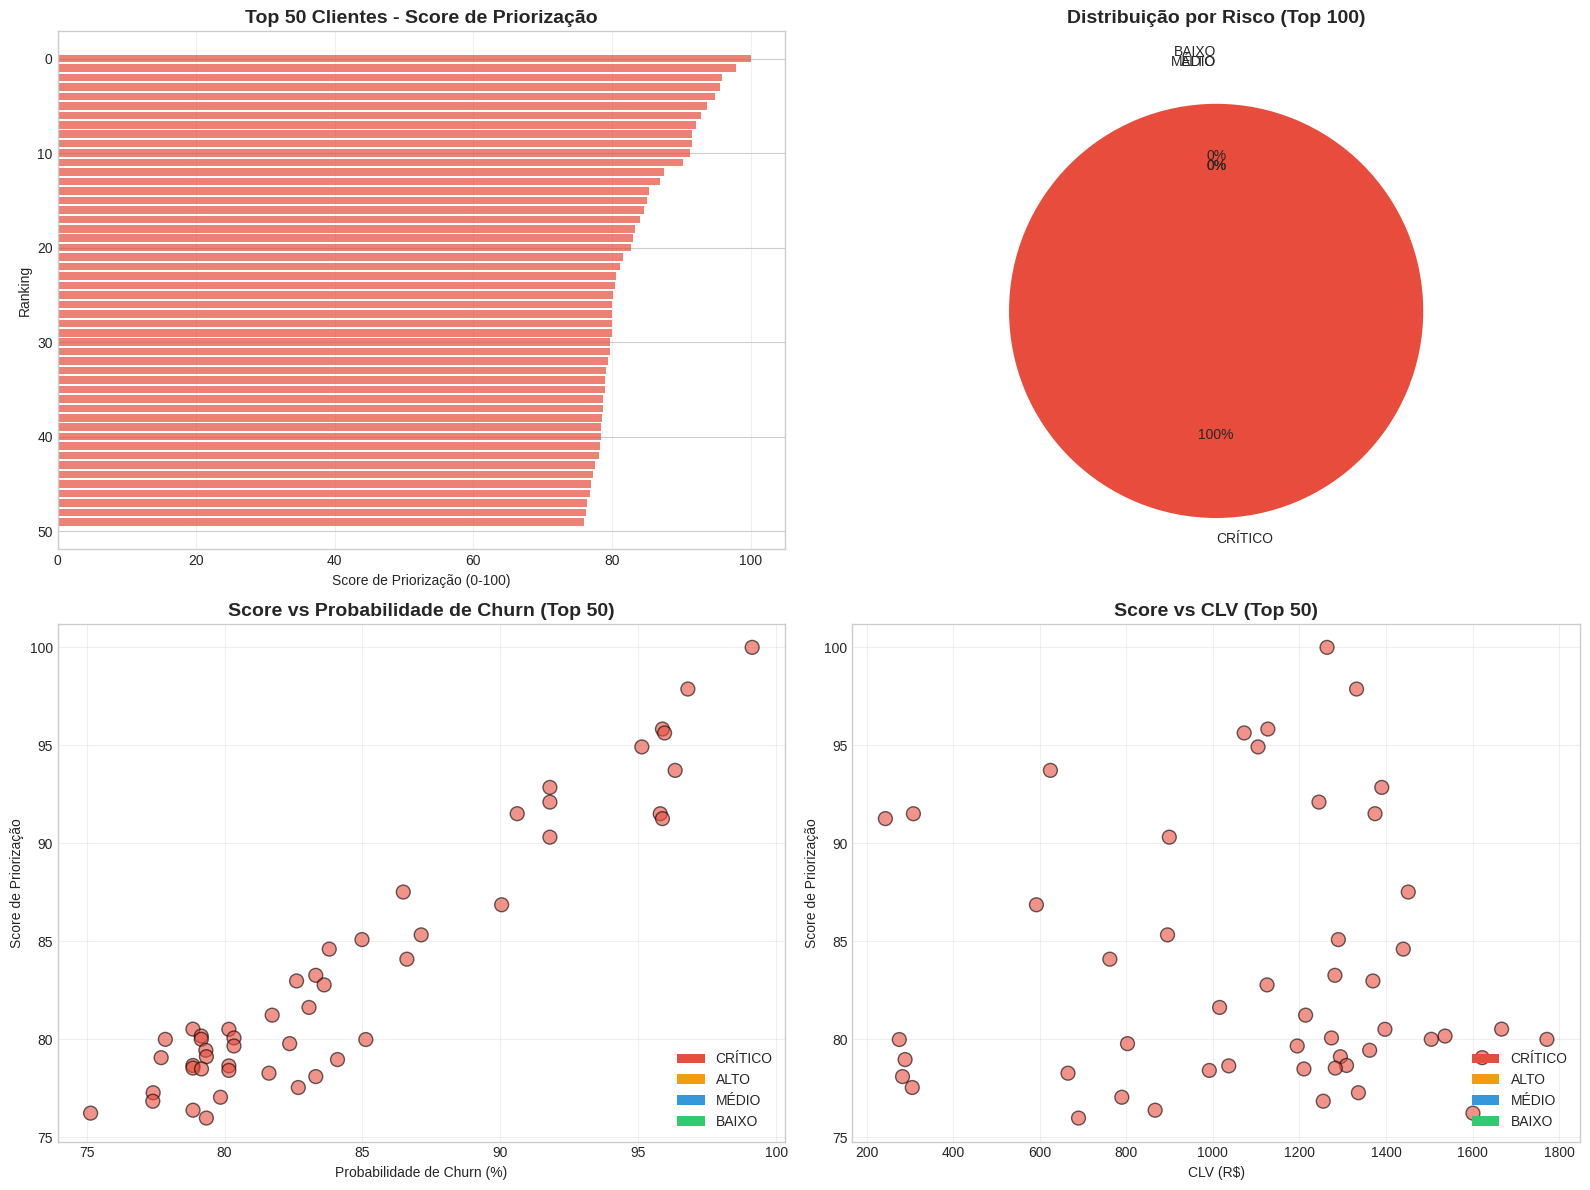

In [80]:
# Visualização
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Score de priorização (Top 50)
top_50 = df.nlargest(50, 'Priority_Score_Normalized')
colors_priority = [colors_map[level] for level in top_50['Risk_Level']]

axes[0, 0].barh(range(len(top_50)), top_50['Priority_Score_Normalized'],
                color=colors_priority, alpha=0.7)
axes[0, 0].set_title('Top 50 Clientes - Score de Priorização', fontweight='bold', fontsize=14)
axes[0, 0].set_xlabel('Score de Priorização (0-100)')
axes[0, 0].set_ylabel('Ranking')
axes[0, 0].invert_yaxis()
axes[0, 0].grid(alpha=0.3, axis='x')

# 2. Distribuição por risco (Top 100)
colors = [colors_map[level] for level in top_risk_dist.index]
axes[0, 1].pie(top_risk_dist.values, labels=top_risk_dist.index, autopct='%1.0f%%',
               colors=colors, startangle=90, explode=(0.1, 0.05, 0, 0))
axes[0, 1].set_title('Distribuição por Risco (Top 100)', fontweight='bold', fontsize=14)

# 3. Score vs Probabilidade (Top 50)
axes[1, 0].scatter(top_50['Churn_Probability']*100,
                   top_50['Priority_Score_Normalized'],
                   c=colors_priority, s=100, alpha=0.6, edgecolors='black')
axes[1, 0].set_title('Score vs Probabilidade de Churn (Top 50)', fontweight='bold', fontsize=14)
axes[1, 0].set_xlabel('Probabilidade de Churn (%)')
axes[1, 0].set_ylabel('Score de Priorização')
axes[1, 0].grid(alpha=0.3)

# Adicionar legenda
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors_map[level], label=level)
                   for level in ['CRÍTICO', 'ALTO', 'MÉDIO', 'BAIXO']]
axes[1, 0].legend(handles=legend_elements, loc='lower right')

# 4. Score vs CLV (Top 50)
axes[1, 1].scatter(top_50['CLV'],
                   top_50['Priority_Score_Normalized'],
                   c=colors_priority, s=100, alpha=0.6, edgecolors='black')
axes[1, 1].set_title('Score vs CLV (Top 50)', fontweight='bold', fontsize=14)
axes[1, 1].set_xlabel('CLV (R$)')
axes[1, 1].set_ylabel('Score de Priorização')
axes[1, 1].grid(alpha=0.3)
axes[1, 1].legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()

### 8.1 Top 20 Clientes Prioritários

---

In [81]:
print("\nTOP 20 CLIENTES PRIORITÁRIOS:")
print("="*80)

top_20_display = top_priority.head(20)[[
    'customerID', 'Churn_Probability', 'CLV', 'Revenue_at_Risk',
    'Risk_Level', 'Recommended_Action', 'Priority_Score_Normalized'
]].copy()

top_20_display.columns = [
    'ID Cliente', 'Prob. Churn', 'CLV', 'Receita em Risco',
    'Nível Risco', 'Ação Recomendada', 'Score Prioridade'
]

# Formatar valores para melhor visualização
top_20_formatted = top_20_display.copy()
top_20_formatted['Prob. Churn'] = top_20_formatted['Prob. Churn'].apply(lambda x: f"{x*100:.1f}%")
top_20_formatted['CLV'] = top_20_formatted['CLV'].apply(lambda x: f"R$ {x:,.0f}")
top_20_formatted['Receita em Risco'] = top_20_formatted['Receita em Risco'].apply(lambda x: f"R$ {x:,.0f}")
top_20_formatted['Score Prioridade'] = top_20_formatted['Score Prioridade'].apply(lambda x: f"{x:.1f}")

display(top_20_formatted)


TOP 20 CLIENTES PRIORITÁRIOS:


,ID Cliente,Prob. Churn,CLV,Receita em Risco,Nível Risco,Ação Recomendada,Score Prioridade
171,1875-QIVME,99.1%,"R$ 1,264","R$ 1,253",CRÍTICO,Contato imediato do gerente de contas,100.0
1090,9036-CSKBW,96.8%,"R$ 1,332","R$ 1,289",CRÍTICO,Contato imediato do gerente de contas,97.9
629,4554-YGZIH,95.9%,"R$ 1,127","R$ 1,081",CRÍTICO,Contato imediato do gerente de contas,95.8
341,6885-PKOAM,96.0%,"R$ 1,072","R$ 1,029",CRÍTICO,Contato imediato do gerente de contas,95.6
618,5240-CAOYT,95.1%,"R$ 1,104","R$ 1,051",CRÍTICO,Contato imediato do gerente de contas,94.9
1109,3391-JSQEW,96.3%,R$ 625,R$ 602,CRÍTICO,Contato imediato do gerente de contas,93.7
38,5380-WJKOV,91.8%,"R$ 1,390","R$ 1,276",CRÍTICO,Contato imediato do gerente de contas,92.9
1259,4187-CINZD,91.8%,"R$ 1,245","R$ 1,143",CRÍTICO,Contato imediato do gerente de contas,92.1
83,9919-YLNNG,90.6%,"R$ 1,375","R$ 1,246",CRÍTICO,Contato imediato do gerente de contas,91.5
1221,3055-MJDSB,95.8%,R$ 308,R$ 295,CRÍTICO,Contato imediato do gerente de contas,91.5


In [82]:
# Verificação da distribuição
risk_counts_top20 = top_priority.head(20)['Risk_Level'].value_counts()

print(f"\nVERIFICAÇÃO - Distribuição por Risco no Top 20:")
for level in ['CRÍTICO', 'ALTO', 'MÉDIO', 'BAIXO']:
    count = risk_counts_top20.get(level, 0)
    pct = count / 20 * 100
    print(f"   • {level}: {count} ({pct:.0f}%)")


VERIFICAÇÃO - Distribuição por Risco no Top 20:
   • CRÍTICO: 20 (100%)
   • ALTO: 0 (0%)
   • MÉDIO: 0 (0%)
   • BAIXO: 0 (0%)


In [83]:
# Validação
criticos_altos = risk_counts_top20.get('CRÍTICO', 0) + risk_counts_top20.get('ALTO', 0)

if criticos_altos >= 18:
    print(f"\nEXCELENTE! {criticos_altos}/20 são CRÍTICO ou ALTO ({criticos_altos/20*100:.0f}%)")
    print("   Priorização está funcionando perfeitamente!")
elif criticos_altos >= 15:
    print(f"\nBOM! {criticos_altos}/20 são CRÍTICO ou ALTO ({criticos_altos/20*100:.0f}%)")
    print("   Priorização está adequada.")
else:
    print(f"\nATENÇÃO! Apenas {criticos_altos}/20 são CRÍTICO ou ALTO")
    print("   Considere ajustar os pesos do score.")


EXCELENTE! 20/20 são CRÍTICO ou ALTO (100%)
   Priorização está funcionando perfeitamente!


### 8.2 Análise Detalhada do Top 20

---

Métricas Financeiras:

    • CLV Médio: R$ 1,053.39
    • CLV Total: R$ 21,067.87
    • Receita em Risco Total: R$ 19,054.20
    • Receita Recuperável: R$ 7,621.68
    • Lucro Líquido Esperado: R$ 4,621.68

Métricas de Risco:

    • Probabilidade Média de Churn: 91.09%
    • Probabilidade Mínima: 82.61%
    • Probabilidade Máxima: 99.13%

Métricas de Ação:

    • Custo Total de Ações: R$ 3,000.00
    • Custo Médio por Cliente:

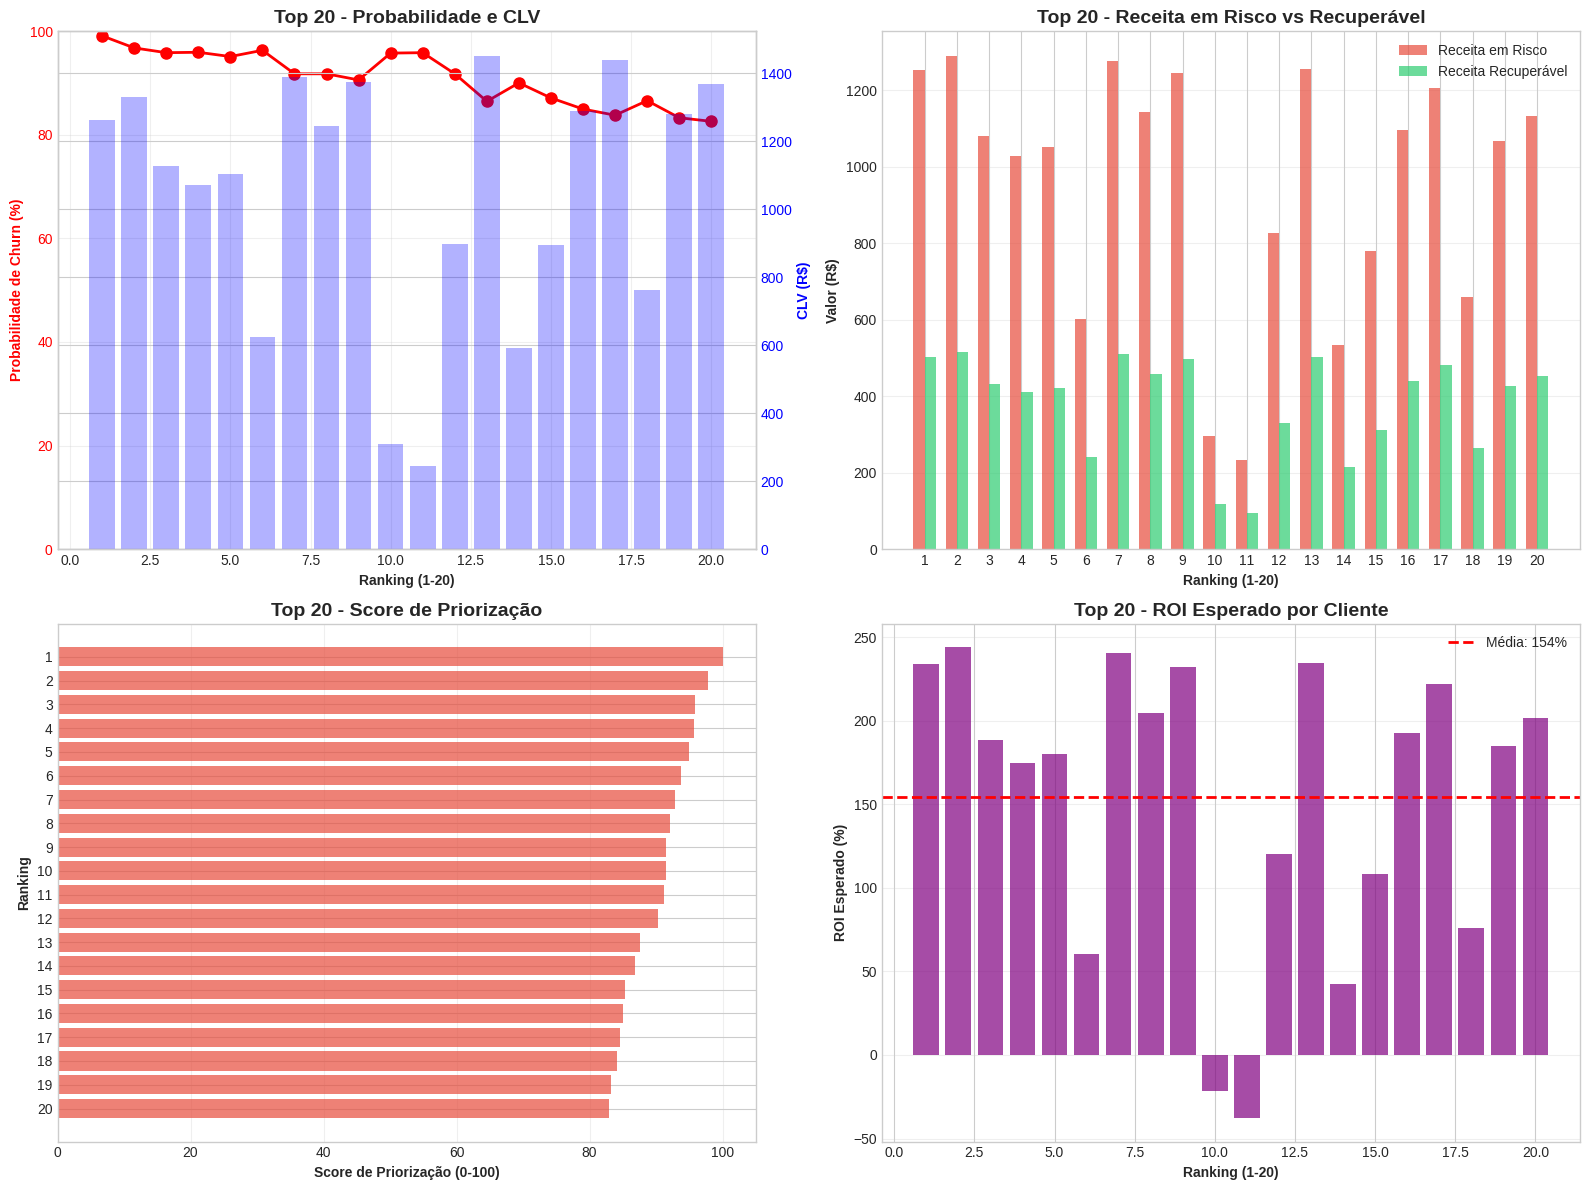

In [84]:
# Estatísticas do Top 20
top_20 = top_priority.head(20)

print(f"\nMétricas Financeiras:")
print(f"   • CLV Médio: R$ {top_20['CLV'].mean():,.2f}")
print(f"   • CLV Total: R$ {top_20['CLV'].sum():,.2f}")
print(f"   • Receita em Risco Total: R$ {top_20['Revenue_at_Risk'].sum():,.2f}")
print(f"   • Receita Recuperável: R$ {top_20['Revenue_Recovered'].sum():,.2f}")
print(f"   • Lucro Líquido Esperado: R$ {top_20['Net_Profit'].sum():,.2f}")

print(f"\nMétricas de Risco:")
print(f"   • Probabilidade Média de Churn: {top_20['Churn_Probability'].mean():.2%}")
print(f"   • Probabilidade Mínima: {top_20['Churn_Probability'].min():.2%}")
print(f"   • Probabilidade Máxima: {top_20['Churn_Probability'].max():.2%}")

print(f"\nMétricas de Ação:")
print(f"   • Custo Total de Ações: R$ {top_20['Action_Cost'].sum():,.2f}")
print(f"   • Custo Médio por Cliente: R$ {top_20['Action_Cost'].mean():.2f}")
print(f"   • ROI Médio Esperado: {top_20['Expected_ROI'].mean():.0f}%")


Métricas Financeiras:
   • CLV Médio: R$ 1,053.39
   • CLV Total: R$ 21,067.87
   • Receita em Risco Total: R$ 19,054.20
   • Receita Recuperável: R$ 7,621.68
   • Lucro Líquido Esperado: R$ 4,621.68

Métricas de Risco:
   • Probabilidade Média de Churn: 91.09%
   • Probabilidade Mínima: 82.61%
   • Probabilidade Máxima: 99.13%

Métricas de Ação:
   • Custo Total de Ações: R$ 3,000.00
   • Custo Médio por Cliente: R$ 150.00
   • ROI Médio Esperado: 154%


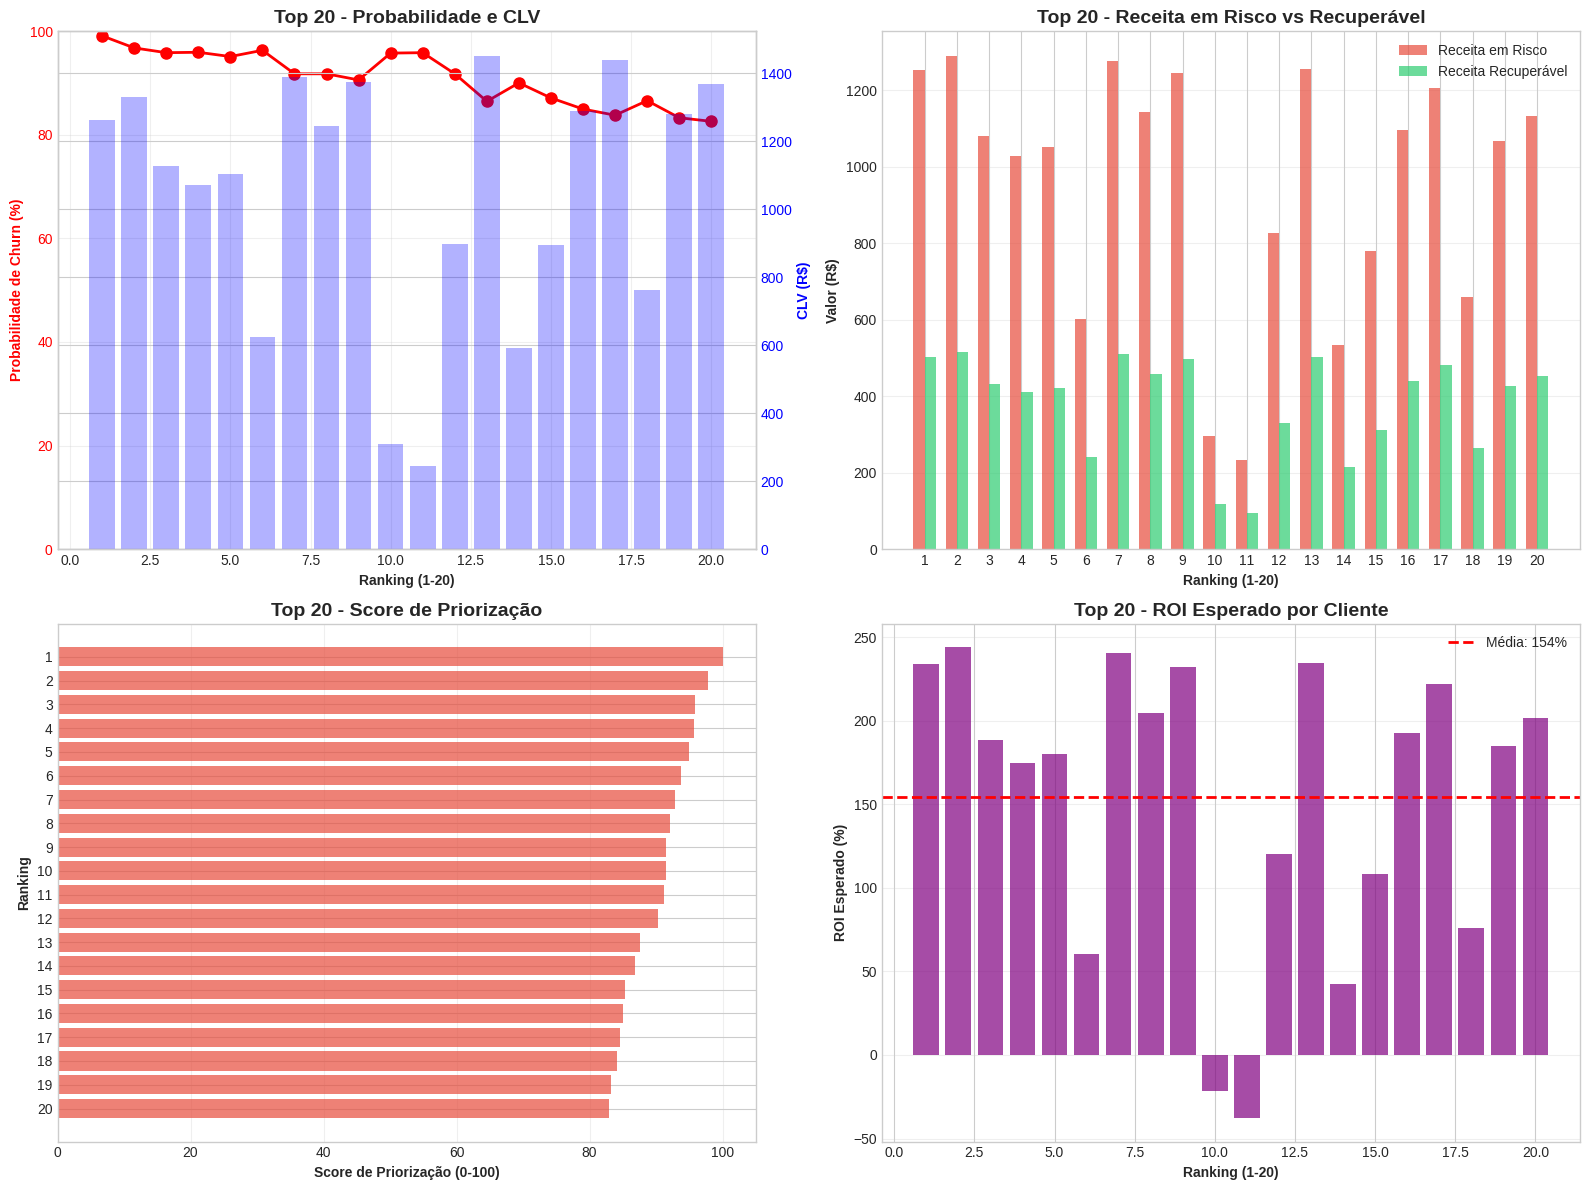

In [85]:
# Visualização detalhada do Top 20
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Probabilidade e CLV do Top 20
x = range(1, 21)
ax1_1 = axes[0, 0]
ax1_2 = ax1_1.twinx()

# Probabilidade (linha)
ax1_1.plot(x, top_20['Churn_Probability'].values * 100,
           marker='o', color='red', linewidth=2, markersize=8, label='Prob. Churn (%)')
ax1_1.set_xlabel('Ranking (1-20)', fontweight='bold')
ax1_1.set_ylabel('Probabilidade de Churn (%)', color='red', fontweight='bold')
ax1_1.tick_params(axis='y', labelcolor='red')
ax1_1.set_ylim(0, 100)

# CLV (barras)
ax1_2.bar(x, top_20['CLV'].values, alpha=0.3, color='blue', label='CLV (R$)')
ax1_2.set_ylabel('CLV (R$)', color='blue', fontweight='bold')
ax1_2.tick_params(axis='y', labelcolor='blue')

axes[0, 0].set_title('Top 20 - Probabilidade e CLV', fontweight='bold', fontsize=14)
axes[0, 0].grid(alpha=0.3)

# 2. Receita em Risco vs Recuperável (Top 20)
width = 0.35
x_pos = np.arange(20)

axes[0, 1].bar(x_pos - width/2, top_20['Revenue_at_Risk'].values,
               width, label='Receita em Risco', color='#e74c3c', alpha=0.7)
axes[0, 1].bar(x_pos + width/2, top_20['Revenue_Recovered'].values,
               width, label='Receita Recuperável', color='#2ecc71', alpha=0.7)
axes[0, 1].set_xlabel('Ranking (1-20)', fontweight='bold')
axes[0, 1].set_ylabel('Valor (R$)', fontweight='bold')
axes[0, 1].set_title('Top 20 - Receita em Risco vs Recuperável', fontweight='bold', fontsize=14)
axes[0, 1].legend()
axes[0, 1].set_xticks(x_pos)
axes[0, 1].set_xticklabels(range(1, 21))
axes[0, 1].grid(alpha=0.3, axis='y')

# 3. Score de Priorização (Top 20)
colors_top20 = [colors_map[level] for level in top_20['Risk_Level']]
axes[1, 0].barh(range(20), top_20['Priority_Score_Normalized'].values,
                color=colors_top20, alpha=0.7)
axes[1, 0].set_xlabel('Score de Priorização (0-100)', fontweight='bold')
axes[1, 0].set_ylabel('Ranking', fontweight='bold')
axes[1, 0].set_title('Top 20 - Score de Priorização', fontweight='bold', fontsize=14)
axes[1, 0].invert_yaxis()
axes[1, 0].set_yticks(range(20))
axes[1, 0].set_yticklabels(range(1, 21))
axes[1, 0].grid(alpha=0.3, axis='x')

# 4. ROI Esperado (Top 20)
axes[1, 1].bar(range(1, 21), top_20['Expected_ROI'].values,
               color='purple', alpha=0.7)
axes[1, 1].axhline(y=top_20['Expected_ROI'].mean(), color='red',
                   linestyle='--', linewidth=2, label=f'Média: {top_20["Expected_ROI"].mean():.0f}%')
axes[1, 1].set_xlabel('Ranking (1-20)', fontweight='bold')
axes[1, 1].set_ylabel('ROI Esperado (%)', fontweight='bold')
axes[1, 1].set_title('Top 20 - ROI Esperado por Cliente', fontweight='bold', fontsize=14)
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

### 8.3 Exportar Lista de Priorização

----

EXPORTANDO LISTA DE PRIORIZAÇÃO:

    Top_20_Criticos: 20 clientes → Top_20_Criticos.csv
    Top_50_Alta_Prioridade: 50 clientes → Top_50_Alta_Prioridade.csv
    Top_100_Prioridade: 100 clientes → Top_100_Prioridade.csv
    Top_500_Monitoramento: 100 clientes → Top_500_Monitoramento.csv

In [86]:
print("\nEXPORTANDO LISTA DE PRIORIZAÇÃO:")
print("="*80)

# Criar diferentes listas de priorização
priority_lists = {
    'Top_20_Criticos': top_priority.head(20),
    'Top_50_Alta_Prioridade': top_priority.head(50),
    'Top_100_Prioridade': top_priority.head(100),
    'Top_500_Monitoramento': top_priority.head(500)
}

# output_dir = Path("../data/processed")
# output_dir.mkdir(parents=True, exist_ok=True)

for list_name, data in priority_lists.items():
    # Selecionar colunas relevantes
    export_data = data[[
        'customerID', 'Churn_Probability', 'Risk_Level',
        'CLV', 'Revenue_at_Risk', 'Revenue_Recovered',
        'Recommended_Action', 'Action_Cost', 'Expected_ROI',
        'Priority_Score_Normalized', 'MonthlyCharges', 'tenure', 'Contract'
    ]].copy()

    # Renomear colunas para português
    export_data.columns = [
        'ID_Cliente', 'Prob_Churn', 'Nivel_Risco',
        'CLV', 'Receita_em_Risco', 'Receita_Recuperavel',
        'Acao_Recomendada', 'Custo_Acao', 'ROI_Esperado',
        'Score_Prioridade', 'Receita_Mensal', 'Tempo_Cliente', 'Tipo_Contrato'
    ]

    # Salvar
    # file_path = output_dir / f"{list_name}.csv"
    file_path = f"{list_name}.csv"
    export_data.to_csv(file_path, index=False)

    print(f"{list_name}: {len(data)} clientes → {file_path}")

print(f"\nListas de priorização exportadas com sucesso!")


EXPORTANDO LISTA DE PRIORIZAÇÃO:
Top_20_Criticos: 20 clientes → Top_20_Criticos.csv
Top_50_Alta_Prioridade: 50 clientes → Top_50_Alta_Prioridade.csv
Top_100_Prioridade: 100 clientes → Top_100_Prioridade.csv
Top_500_Monitoramento: 100 clientes → Top_500_Monitoramento.csv

Listas de priorização exportadas com sucesso!


## 9. Dashboard Executivo (Resumo Visual)

----

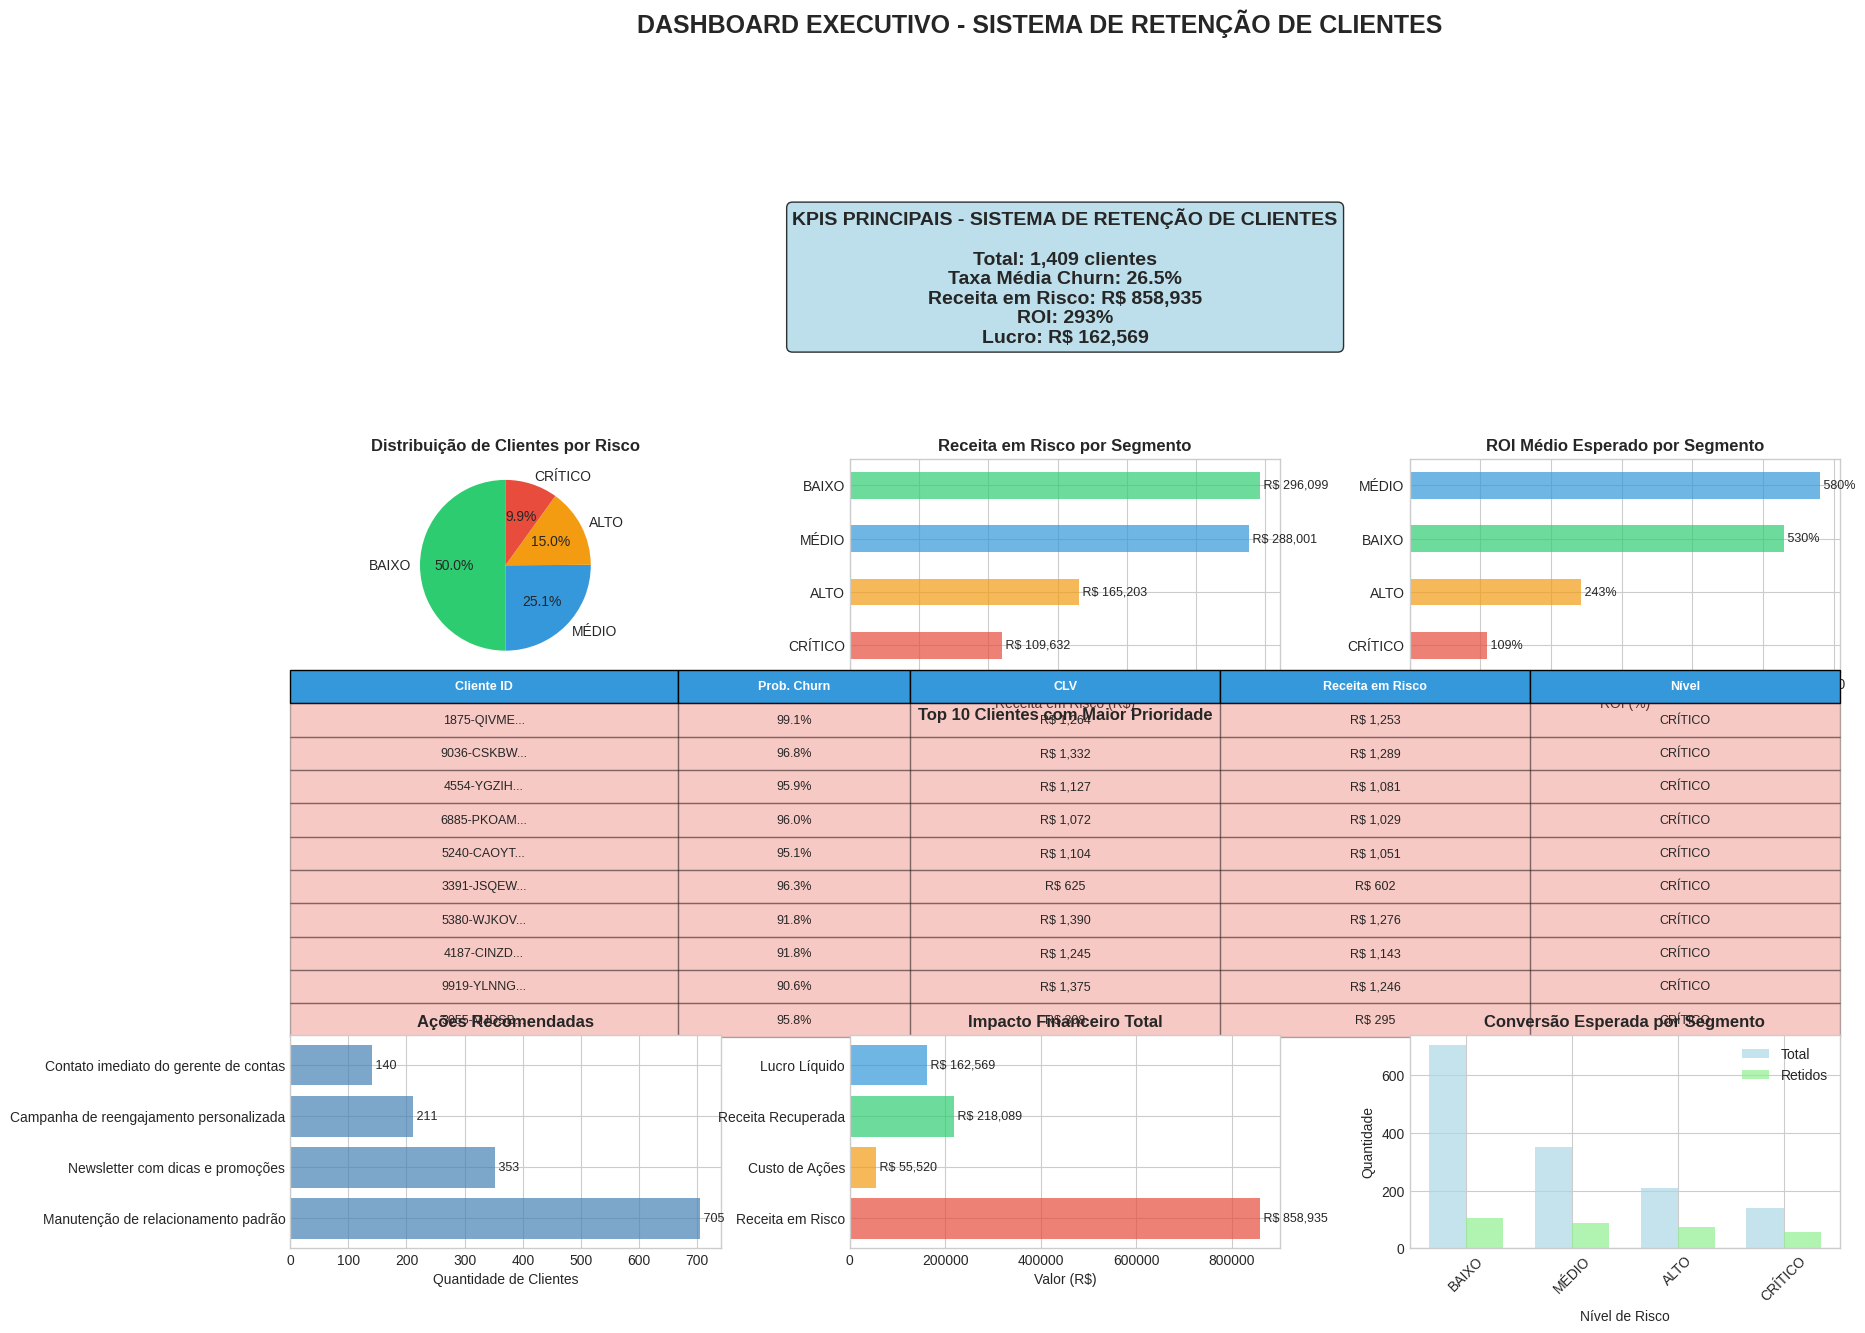

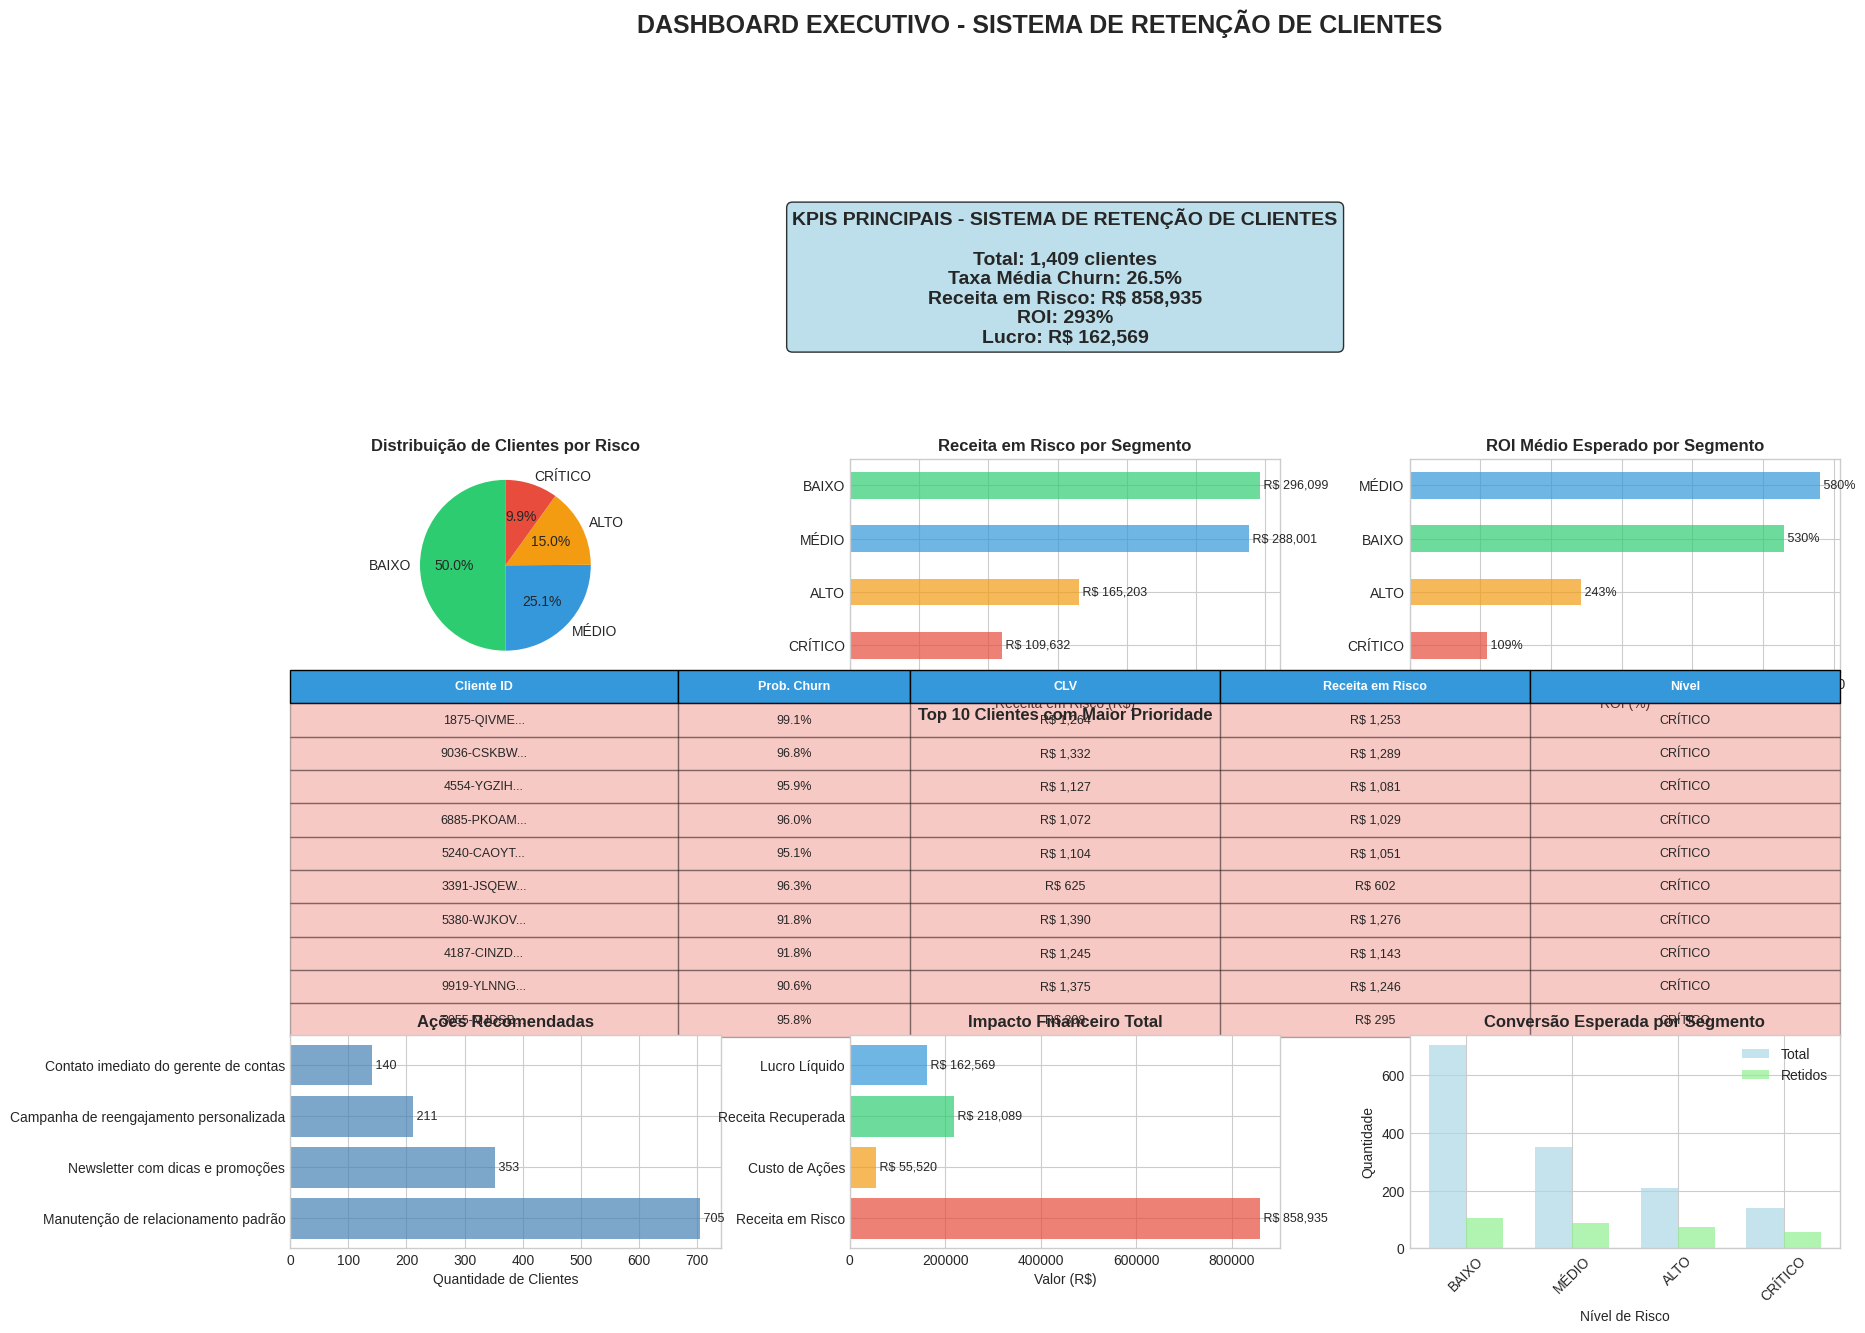


Dashboard salvo como: executive_dashboard.png


In [94]:
# Dashboard consolidado
fig = plt.figure(figsize=(20, 14))
gs = fig.add_gridspec(4, 3, hspace=0.35, wspace=0.3)

# 1. KPIs Principais (topo) - CORRIGIDO
ax1 = fig.add_subplot(gs[0, :])
ax1.axis('off')

churn_rate = float(df['Churn_Probability'].mean() * 100)

# Criar texto sem problemas de parsing
kpis_lines = [
    "KPIS PRINCIPAIS - SISTEMA DE RETENÇÃO DE CLIENTES",
    "",
    f"Total: {len(df):,} clientes",
    f"Taxa Média Churn: {churn_rate:.1f}%",
    f"Receita em Risco: R$ {float(total_revenue_at_risk):,.0f}",
    f"ROI: {float(overall_roi):.0f}%",
    f"Lucro: R$ {float(net_profit):,.0f}"
]

kpis_text = "\n".join(kpis_lines)

ax1.text(0.5, 0.5, kpis_text, ha='center', va='center',
         fontsize=14, fontweight='bold',
         bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

# 2. Distribuição por Nível de Risco
ax2 = fig.add_subplot(gs[1, 0])
risk_counts = df['Risk_Level'].value_counts()
colors = [colors_map[level] for level in risk_counts.index]

wedges, texts, autotexts = ax2.pie(risk_counts, labels=risk_counts.index, autopct='%1.1f%%',
                                     colors=colors, startangle=90)
ax2.set_title('Distribuição de Clientes por Risco', fontweight='bold', fontsize=12)

# 3. Receita em Risco por Segmento
ax3 = fig.add_subplot(gs[1, 1])
revenue_by_risk = df.groupby('Risk_Level')['Revenue_at_Risk'].sum().sort_values(ascending=True)
colors_bar = [colors_map[level] for level in revenue_by_risk.index]

revenue_by_risk.plot(kind='barh', ax=ax3, color=colors_bar, alpha=0.7)
ax3.set_title('Receita em Risco por Segmento', fontweight='bold', fontsize=12)
ax3.set_xlabel('Receita em Risco (R$)')
ax3.set_ylabel('')

# Adicionar valores
for i, v in enumerate(revenue_by_risk.values):
    ax3.text(v, i, f' R$ {v:,.0f}', va='center', fontsize=9)

# 4. ROI Esperado por Segmento
ax4 = fig.add_subplot(gs[1, 2])
roi_by_risk = df.groupby('Risk_Level')['Expected_ROI'].mean().sort_values(ascending=True)
colors_bar = [colors_map[level] for level in roi_by_risk.index]

roi_by_risk.plot(kind='barh', ax=ax4, color=colors_bar, alpha=0.7)
ax4.set_title('ROI Médio Esperado por Segmento', fontweight='bold', fontsize=12)
ax4.set_xlabel('ROI (%)')
ax4.set_ylabel('')

# Adicionar valores
for i, v in enumerate(roi_by_risk.values):
    ax4.text(v, i, f' {v:.0f}%', va='center', fontsize=9)

# 5. Top 10 Clientes em Risco
ax5 = fig.add_subplot(gs[2, :])
top_10_risk = df.nlargest(10, 'Priority_Score_Normalized')[
    ['customerID', 'Churn_Probability', 'CLV', 'Revenue_at_Risk', 'Risk_Level']
]

# Criar tabela
table_data = []
for idx, row in top_10_risk.iterrows():
    table_data.append([
        row['customerID'][:10] + '...',
        f"{row['Churn_Probability']*100:.1f}%",
        f"R$ {row['CLV']:,.0f}",
        f"R$ {row['Revenue_at_Risk']:,.0f}",
        row['Risk_Level']
    ])

table = ax5.table(cellText=table_data,
                  colLabels=['Cliente ID', 'Prob. Churn', 'CLV', 'Receita em Risco', 'Nível'],
                  cellLoc='center',
                  loc='center',
                  colWidths=[0.25, 0.15, 0.2, 0.2, 0.2])

table.auto_set_font_size(False)
table.set_fontsize(9)
table.scale(1, 2)

# Colorir header
for i in range(5):
    table[(0, i)].set_facecolor('#3498db')
    table[(0, i)].set_text_props(weight='bold', color='white')

# Colorir linhas por risco
for i, row in enumerate(top_10_risk.itertuples(), 1):
    color = colors_map[row.Risk_Level]
    for j in range(5):
        table[(i, j)].set_facecolor(color)
        table[(i, j)].set_alpha(0.3)

ax5.axis('off')
ax5.set_title('Top 10 Clientes com Maior Prioridade', fontweight='bold', fontsize=12, pad=20)

# 6. Distribuição de Ações Recomendadas
ax6 = fig.add_subplot(gs[3, 0])
action_counts = df['Recommended_Action'].value_counts()
ax6.barh(action_counts.index, action_counts.values, color='steelblue', alpha=0.7)
ax6.set_title('Ações Recomendadas', fontweight='bold', fontsize=12)
ax6.set_xlabel('Quantidade de Clientes')

# Adicionar valores
for i, v in enumerate(action_counts.values):
    ax6.text(v, i, f' {v:,}', va='center', fontsize=9)

# 7. Impacto Financeiro Total
ax7 = fig.add_subplot(gs[3, 1])
financial_summary = pd.DataFrame({
    'Métrica': ['Receita em Risco', 'Custo de Ações', 'Receita Recuperada', 'Lucro Líquido'],
    'Valor': [
        total_revenue_at_risk,
        total_action_cost,
        total_revenue_recovered,
        net_profit
    ]
})

colors_financial = ['#e74c3c', '#f39c12', '#2ecc71', '#3498db']
bars = ax7.barh(financial_summary['Métrica'], financial_summary['Valor'],
                color=colors_financial, alpha=0.7)
ax7.set_title('Impacto Financeiro Total', fontweight='bold', fontsize=12)
ax7.set_xlabel('Valor (R$)')

# Adicionar valores
for i, v in enumerate(financial_summary['Valor'].values):
    ax7.text(v, i, f' R$ {v:,.0f}', va='center', fontsize=9)

# 8. Resumo de Conversão Esperada
ax8 = fig.add_subplot(gs[3, 2])
conversion_summary = df.groupby('Risk_Level').agg({
    'customerID': 'count',
    'Expected_Retained': 'sum'
}).round(0)

conversion_summary['Taxa_Conversao'] = (
    conversion_summary['Expected_Retained'] / conversion_summary['customerID'] * 100
).round(1)

x = range(len(conversion_summary))
width = 0.35

bars1 = ax8.bar([i - width/2 for i in x], conversion_summary['customerID'],
                width, label='Total', color='lightblue', alpha=0.7)
bars2 = ax8.bar([i + width/2 for i in x], conversion_summary['Expected_Retained'],
                width, label='Retidos', color='lightgreen', alpha=0.7)

ax8.set_xlabel('Nível de Risco')
ax8.set_ylabel('Quantidade')
ax8.set_title('Conversão Esperada por Segmento', fontweight='bold', fontsize=12)
ax8.set_xticks(x)
ax8.set_xticklabels(conversion_summary.index, rotation=45)
ax8.legend()

# Título geral
fig.suptitle('DASHBOARD EXECUTIVO - SISTEMA DE RETENÇÃO DE CLIENTES',
             fontsize=18, fontweight='bold', y=0.995)

plt.tight_layout()
plt.show()

# Salvar dashboard
dashboard_path = Path("executive_dashboard.png")
dashboard_path.parent.mkdir(parents=True, exist_ok=True)
fig.savefig(dashboard_path, dpi=300, bbox_inches='tight')

print(f"\nDashboard salvo como: {dashboard_path}")

## 10. Exportação de Resultados para Produção

----

Dataset completo salvo:

    customers_with_recommendations.csv
    Resumo por segmento salvo: segment_summary.csv
    Playbook de ações salvo: retention_playbook.json
    Métricas de negócio salvas: business_metrics.json

In [95]:
# 1. Dataset completo com segmentação e recomendações
# output_path = Path("../data/processed/customers_with_recommendations.csv")
output_path = Path("customers_with_recommendations.csv")
df.to_csv(output_path, index=False)
print(f"Dataset completo salvo: {output_path}")

# 2. Resumo por segmento
segment_summary = df.groupby('Risk_Level').agg({
    'customerID': 'count',
    'Churn_Probability': 'mean',
    'CLV': 'mean',
    'Revenue_at_Risk': 'sum',
    'Action_Cost': 'sum',
    'Revenue_Recovered': 'sum',
    'Net_Profit': 'sum',
    'Expected_ROI': 'mean',
    'Expected_Retained': 'sum'
}).round(2)

segment_summary.columns = [
    'Total_Clientes', 'Prob_Churn_Media', 'CLV_Medio',
    'Receita_em_Risco', 'Custo_Total', 'Receita_Recuperada',
    'Lucro_Liquido', 'ROI_Medio', 'Clientes_Retidos'
]

# summary_path = Path("../data/processed/segment_summary.csv")
summary_path = Path("segment_summary.csv")
segment_summary.to_csv(summary_path)
print(f"Resumo por segmento salvo: {summary_path}")

# 3. Playbook de ações
# playbook_path = Path("../data/processed/retention_playbook.json")
playbook_path = Path("retention_playbook.json")
with open(playbook_path, 'w', encoding='utf-8') as f:
    json.dump(action_mapping, f, indent=4, ensure_ascii=False)
print(f"Playbook de ações salvo: {playbook_path}")

# 4. Métricas gerais
metrics_summary = {
    'data_geracao': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'total_clientes': int(len(df)),
    'taxa_churn_media': float(df['Churn_Probability'].mean()),
    'clv_total': float(df['CLV'].sum()),
    'receita_em_risco': float(total_revenue_at_risk),
    'custo_total_acoes': float(total_action_cost),
    'receita_recuperavel': float(total_revenue_recovered),
    'lucro_liquido': float(net_profit),
    'roi_geral': float(overall_roi),
    'distribuicao_risco': {
        'CRITICO': int(risk_distribution.get('CRÍTICO', 0)),
        'ALTO': int(risk_distribution.get('ALTO', 0)),
        'MEDIO': int(risk_distribution.get('MÉDIO', 0)),
        'BAIXO': int(risk_distribution.get('BAIXO', 0))
    }
}

# metrics_path = Path("../data/processed/business_metrics.json")
metrics_path = Path("business_metrics.json")
with open(metrics_path, 'w', encoding='utf-8') as f:
    json.dump(metrics_summary, f, indent=4, ensure_ascii=False)
print(f"Métricas de negócio salvas: {metrics_path}")

print("\nTodos os arquivos exportados com sucesso!")

Dataset completo salvo: customers_with_recommendations.csv
Resumo por segmento salvo: segment_summary.csv
Playbook de ações salvo: retention_playbook.json
Métricas de negócio salvas: business_metrics.json

Todos os arquivos exportados com sucesso!


## Notebook 05 Concluído

---

1. Segmentação de clientes em 4 níveis de risco (por percentis)

2. Sistema de recomendação de ações personalizadas

3. Cálculo de CLV e impacto financeiro

4. Análise de ROI por segmento

5. Simulação de cenários (conservador/realista/otimista)

6. **Priorização corrigida** (Score Ponderado: 60% prob + 40% CLV)

7. Dashboard executivo visual

8. Exportação de resultados para produção

## Principais Resultados:

----

- **Total de Clientes:** 1,409

- **Receita em Risco:** $ 858,934.71

- **Receita Recuperável:** $ 218,088.83

- **Lucro Líquido Estimado:** $ 162,568.83

- **ROI Geral:** 293%

## Próximos Passos:

----

**Dashboard Interativo em Streamlit**

Criar interface web para:

    - Visualização interativa dos resultados
    - Filtros dinâmicos por segmento
    - Simulação de cenários em tempo real
    - Exportação de listas de ação

